[Jordà, Ò., & Taylor, A. M. (2016). The time for austerity: estimating the average treatment effect of fiscal policy. _The Economic Journal_, _126_(590), 219-255.](https://onlinelibrary.wiley.com/doi/abs/10.1111/ecoj.12332)

Replication Code Downloaded from https://sites.google.com/site/oscarjorda/home/local-projections

[Download this jupyternotebook from here](https://github.com/htdanil/referenced_to_github/blob/master/GF0004_Jorda_Taylor_%282016%29_The_time_for_austerity__REPLICATION_WORK/Replication.ipynb)

<a class='anchor' id='table_of_contents'></a>

# Table of Contents
* [Initiating environment and downloading datasets](#initiating_env)
* [Preparation of dataset](#dataset)
* [Table 1 : Fiscal Multiplier, Effect of d.CAPB, OLS Estimates](#table1)
* [Table 2 and A1](#tbl2A1)
     - [Table 2 : Fiscal Multiplier, Effect of d.CAPB, OLS Estimates, Booms vs Slumps](#tbl2A1)
     - [Table 2 - Panel (a)](#table2_a)
     - [Table 2 - Panel (b)](#table2_b)
     - [Table A1 : Fiscal Multiplier, d.CAPB, OLS Estimate, Booms vs Slumps (world GDP growth included)](#tableA1)
     - [Table A1 - Panel (a)](#tableA1_a)
     - [Table A1 - Panel (b)](#tableA1_b)
* [Table 3 : Fiscal Multiplier, Effect of d.CAPB, IV Estimates](#table3)
* [Table 4 and A2](#tbl4A2)
     - [Table 4 : Fiscal Multiplier, Effect of d.CAPB, IV Estimates (binary IV), Booms vs Slumps](#table4)
     - [Table A2 : Fiscal Multiplier, d.CAPB, IV Estimate (binary), Booms vs Slumps (World GDP growth included)](#tableA2)
* [Table 5 : Checking for Balance in Treatment and Control Sub-populations](#table5)
* [Table 6 : Omitted Variables Explain Output Fluctuations](#table6)
* [Table 7 : Fiscal Treatment Regression, Pooled Probit Estimators (average marginal effects)](#table7)
* [Table 8 : Average Treatment Effect of Fiscal Consolidation, AIPW Estimates, Full Sample](#table8)
* [Table 9 : Average Treatment Effect of Fiscal Consolidation, AIPW Estimates, Booms Vs Slumps](#table9)
---
* [Figure 1 : Fig 1. An example of Allocation Bias and the IPWRA Estimator](#fig1)
* [Figure 2 : Overlap Check : Empirical Distributions of the Treatment Propensity Score](#fig2)
* [Figure 3 : Comparing AIPW and IV Estimates of the Response](#fig3)
    - [Figure 3 using python](#fig3_python)

<a class="anchor" id="initiating_env"></a>

------
    
# Initiating environment and downloading datasets
---

In [1]:
#--------------------------------------------------------------------------------------------
# Necessary packages loading for python
#--------------------------------------------------------------------------------------------
import ipystata #package for executing stata code from python
import wget
from pathlib import Path
import os

In [2]:
#--------------------------------------------------------------------------------------------
# Downloading data from Github repository
#--------------------------------------------------------------------------------------------
path = 'https://github.com/htdanil/referenced_to_github/raw/master/GF0004_Jorda_Taylor_(2016)_The_time_for_austerity__REPLICATION_WORK/dataset/'
datasets = ['01_wdi_worldgdp.xlsx',
           '02_JST_panel2_v1.dta',
           '03_IMF-fiscalshocks.dta',
           '04_Leigh_database.dta',
           '05_IMFWEO_AUTIRL.dta',
           '06_03YR.xlsx',
           '07_aut_irl_8Apr2013.xlsx',
           '08_austria_gaggl.dta']

#creating data folder for downloading datasets
try:
    os.mkdir('data')
except:
    pass

for x in datasets:
    already_exists = len(list(Path().rglob(x))) #checking whether file exists or not
    
    if already_exists == 0:
        wget.download(path + x, 'data')

<a class='anchor' id='dataset'></a>

---
# Preparation of dataset (dataset.do)
---

In [3]:
%%capture
%%stata -os -cwd
clear
*#================================================================
*# importing excel data and saving it in tempfile for later use
*#================================================================
import excel  using data/01_wdi_worldgdp.xlsx, firstrow
tempfile wgdp
save `wgdp'

*#================================================================
* #read in the JST dataset
*#================================================================
use data/02_JST_panel2_v1.dta, clear
replace iso="PRT" if iso=="POR"

*#================================================================
* #read in the full IMF-GLP dataset from Leigh and merging it
*#================================================================
sort iso year
merge 1:1 iso year using data/03_IMF-fiscalshocks.dta
drop _merge //#dropping the column created on the merge process

*#================================================================
* #get the Leigh and AA variables
*#================================================================
sort iso year
tempfile data
save `data'

use data/04_Leigh_database.dta, clear
gen iso = wdicode
merge 1:1 iso year using `data'
drop _merge

*#================================================================
* #merge in AUT IRL data from WEO Oct 2012 to fill some gaps
* #to deal with missing data for AUT and IRL
*#================================================================
merge 1:1 iso year using data/05_IMFWEO_AUTIRL.dta
drop _merge
replace debtgdp = debtgdpweo/100 if iso=="IRL"|iso=="AUT"
gen rgdpnew = rgdpbarro
replace rgdpnew = rgdpweo if iso=="IRL"|iso=="AUT"

*#================================================================
* #cut down to the 17 country sample to match the IMF
*#================================================================
drop if iso=="CHE"
drop if iso=="NOR"

*#================================================================
* #read in world GDP back in here
*#================================================================
merge m:1 year using `wgdp'
drop _merge

In [4]:
%%capture
%%stata -o stata_df -os
*#================================================================
* #create treatment variable (fiscal consolidation action according to IMF)
*#================================================================
gen treatment = 0 if year>=1978 & year<=2007
replace treatment = 1 if total ~= . //# set treatment variable to 1 if total variable is not set to null
gen control = 1-treatment //#generating control variable which is opposite of treatment. Control means not received any treatment.

replace total = 0 if treatment == 0
replace tax = 0 if treatment == 0
replace spend = 0 if treatment == 0

In [5]:
%%stata -os
*#================================================================
* #defining panel dataset
*#================================================================
capture drop ccode //# does not show any error if drop ccode throws any error
egen ccode=group(iso)
sort iso year
xtset ccode year //#defining panel data


(1 missing value generated)

       panel variable:  ccode (unbalanced)
        time variable:  year, 1977 to 2011
                delta:  1 year



In [6]:
%%capture
%%stata -os
*#================================================================================
* #treatment happens at t=1 in IMF study setup, but known at t=0
* #use ftreatment as the indicator of policy choice at t=0 to match the IMF setup
*#=================================================================================
gen ftreatment = f.treatment

* #drop events around time of German reunification to match AA variable
replace ftreatment=. if iso=="DEU" & year ==1990 | iso=="DEU" & year ==1991


* #save to tempfile for later use
tempfile data
save `data'

In [7]:
%%capture
%%stata -os
*#================================================================================
* #more gaps to fill for broad datset
*** #read in short- and long-term interest rates for IRL // 
*** #short-term data from Israel Malkin
*** #long-term data from Alan
*#================================================================================
clear
import excel using data/06_03YR.xlsx, sheet(IRL) firstrow

gen d = date(date, "MDY")
format d %td
gen year = year(d)
rename IRL stir
collapse stir, by(year) //# creating average of stir variable by year
replace stir=16 if year == 1992 // #this is a fix for the code error in the data
replace stir = stir/100 
gen iso = "IRL"

tempfile sIRL
save `sIRL'
clear

import excel  using data/07_aut_irl_8Apr2013.xlsx, firstrow //# IRL ltrate from Alan
destring year, replace //#converting year from string to numerical value
keep year iso ltrate 
keep if iso=="IRL"
merge 1:1 iso year using `sIRL'
drop _merge
tempfile IRL
save `IRL'
clear

In [8]:
%%capture
%%stata -os
*#================================================================================
*** #read in data for AUT from Paul Gaggl
*#================================================================================
use data/08_austria_gaggl.dta
rename  at_i_3m_a stir
rename at_i_10y_a ltrate
replace stir = stir/100
replace ltrate = ltrate/100
merge 1:1 iso year using `IRL'
drop _merge

merge 1:1 iso year using `data'
drop _merge

gen lrgdp   = log(rgdpbarro) // #real GDP index from Barro
gen lrcon   = log(rconsbarro) // #real consumption index from Barro
gen lmoney  = log(money) // #M2, more or less
gen lstocks = log(stocks) // #Stock indices
gen lnarrow = log(narrowm) // #M1, more or less
gen cay = ca/gdp // #Current Account over GDP ratio
gen lloans  = log(loans1)

tempfile data
save `data'
clear

In [9]:
%%capture
%%stata -os
*#================================================================================
*** #read in data from Alan for AUT and IRL except for interest rates 
* #(goes in here because he already applied the necessary transformations)
*#================================================================================

import excel using data/07_aut_irl_8Apr2013.xlsx, firstrow
destring year, replace
drop ltrate
merge 1:1 year iso using `data'
drop _merge

replace ccode = 2 if ccode==. & iso=="AUT"
replace ccode = 11 if ccode==. & iso=="IRL"

replace cay = cay/100 if iso=="AUT" | iso=="IRL"
gen lcpi    = log(cpi)  //#CPI
gen lpop    = log(pop)

replace lrgdp = log(rgdp) - lpop if iso=="AUT" | iso=="IRL" //# log of per capita GDP

gen rprv  = lloans - lcpi - lpop  // #real per capita private loans
replace rprv = log(realloans) - lpop if iso=="AUT" | iso=="IRL"

gen riy = iy*rgdpbarro // #real per capita investment
replace riy = realinv/pop if iso=="AUT" | iso=="IRL"
gen lriy = log(riy)

gen rlmoney = lmoney - lcpi

sort ccode year
gen dlrgdp  = 100*d.lrgdp // #Annual real per capita GDP growth in percent
gen dlriy = 100*d.lriy // #Annual real per capita investment growth in percent
gen dlcpi   = 100*d.lcpi // #Annual inflation in percent
gen dlrcon  = 100*d.lrcon // #Annual real consumption growth in percent

gen drprv = 100*d.rprv // #Annual real per capita private loan growth 
gen drlmoney= 100*d.rlmoney  // #Annual Growth in M2 

replace cay = 100*cay
replace stir = 100*stir
replace ltrate = 100*ltrate 

In [10]:
%%capture
%%stata -os
*#================================================================================
* #match IMF: cumulate IMF real GDP growth rate (N=17) to recoup levels
* #g = growth of real GDP (OECD)
*#================================================================================
gen dlogy = log(1+g) if year>=1978 //# log(1+g) is to create log of Y difference variable i.e. growth of Y using log difference
by ccode: gen logyIMF=sum(dlogy) if year>=1978 // #creating cummulative column of dlogy
by ccode: replace logyIMF=0 if year==1977 // #start year =0


---
**datset now complete, now preparing for the empirical analysis**

---

In [11]:
%%capture
%%stata -os
*#================================================================================
* #define dependent variable and lags
*#================================================================================
gen ly = 100*logyIMF //# converted in % multiplying by 100. logyIMF is cummulative growth rate by ccode
gen dly = d.ly //#non-cummulative growth rate (I guess)
gen ldly = l.dly

*#================================================================================
* #generate lags of the broad set of controls
*#================================================================================
gen ldrprv = l.drprv 
gen ldlcpi = l.dlcpi
gen ldlriy = l.dlriy 
gen lstir = l.stir 
gen lltrate = l.ltrate 
gen lcay = l.cay

*#================================================================================
* #construct the HP filter of log y
*#================================================================================
drop if year > 2011

bysort ccode: hprescott ly, stub(HP) smooth(100) //#creates separate columns for each ccode
* #VERY HIGH smoothing (cf 6.25 Ravn-Uhlig)
* #but we want something like "output gap"

*#since the above code creates separate columns for HP extraction for each ccode,
*# the following code creates a single column for cyclical component
summarize ccode
local countries = r(max) //#number of countries

gen hply=.
forvalues i=1/`countries' {
	replace hply = HP_ly_`i' if ccode==`i'
}

*#================================================================================
* #now drop unwanted years after the HP filtering
* #all regressions are restricted to year>=1980 & year<=2007
*#================================================================================
drop if year<=1977
drop if year>=2008

*#================================================================================
* #bins - dividing whole dataset into group based on cyclical component of HP filter on Y
*#================================================================================
gen boom = cond(hply > +0,1,0) //#if positive boom
gen slump = 1 - boom

gen Hi = cond(hply > +1, 1, 0) //# if greater than +1 High, from +1 to -1 Medium and Less or equal to -1 low
gen Mid = cond(hply>-1 & hply<= +1, 1, 0)
gen Low = 1 - Hi - Mid

*#================================================================================
* #dummy interactions
*#================================================================================
gen ccodeLMH = ccode
replace ccodeLMH =  ccodeLMH+100 if Mid==1 //#greater than 100 ccode represents Medium, greater than 200 High, and less than 100 low
replace ccodeLMH =  ccodeLMH+200 if Hi==1
tabulate ccodeLMH, gen(ccodeLMHdum) //# generating dummy variable based on tabulation of ccodeLMH

*#================================================================================
* #dep vars for h-step ahead forecast (h=1,...,5)
*#================================================================================

local var ly ftreatment // #ftreatment depvar used in Table A5. storing ly and ftreatment variable in local macro named var

foreach v of local var { //#looping through var macro i.e. ly and ftreatment
    forvalues i=1/5 { //#looping through horizon 1 to 5

        if "`v'"=="ly" {
            gen `v'`i' = f`i'.`v' - `v' //#generating dependent variable, Y(t+h) - Y(t)
        }

        if "`v'"=="ftreatment" { //#creating ftreatment variable for horizon 
            gen `v'`i' = f`i'.`v'
        }
        label var `v'`i' "Year `i'" //#labelling newly created variable
    }
}

gen ly6 = (ly1+ly2+ly3+ly4+ly5)
label var ly6 "Sum" //# sum column for total effect

*#================================================================================
* # transform and interact AA dCAPB measure
*#================================================================================
gen AA = AA_dcapb * 100
gen fAA = f.AA
gen lfAA = l.fAA //# AA and lfAA is the same thing
gen fAAMid = fAA * Mid
gen fAALo = fAA * Lo

* #housekeeping
tab year, gen(y)
tabulate year, gen(dumyr)
tabulate iso, gen(dumiso)

*#================================================================================
* #dmdum = demeaned dummies
* #demeaned dummy variable
*#================================================================================
forvalues k = 1/17 {
    gen dmdumiso`k' = dumiso`k' - 1/17 //# mean is 1 divided by 17 (1/17). There is 17 countries.
}

*#================================================================================
* #dml0dly dml1dly = demeaned growth rates
* # demeaned growth rates
*#================================================================================
sum dly
gen dml0dly = dly - r(mean)

sum ldly
gen dml1dly = ldly - r(mean)


<a class='anchor' id='table1'></a>

[Go to Table of Contents](#table_of_contents)

---
# Table 1 (table1.do)
---

![Table1](https://github.com/htdanil/referenced_to_github/raw/master/GF0004_Jorda_Taylor_%282016%29_The_time_for_austerity__REPLICATION_WORK/results/table1.PNG)

### For the summarized result of the code in the following cell, click the link below 

[Link to see summarized results](https://github.com/htdanil/referenced_to_github/blob/master/GF0004_Jorda_Taylor_%282016%29_The_time_for_austerity__REPLICATION_WORK/results/table1_summarized.pdf)

In [12]:
%%stata -os
*#================================================================================
* #Table 1: Fiscal muliplier, d.CAPB, OLS estimate
*#================================================================================

gen lgfAA = 0
replace lgfAA = fAA if abs(fAA)>1.5 //# Fiscal multiplier, large change in CAPB (> 1.5%)

gen smfAA = 0
replace smfAA = fAA if abs(fAA)<=1.5 //# Fiscal multiplier, small change in CAPB (<= 1.5%)

*** #OLS AA all changes in dCAPB full sample
label var fAA "Fisc multiplier. Full sample"
label var lgfAA "Fisc multiplier. Large Cons."
label var smfAA "Fisc multiplier. Small Cons."


forvalues i=1/6 {
    * #the dummy for the U.S. is dropped to avoid collinearity with the constant
    * #specification a la AA
    reg ly`i'   fAA ///
        hply dml0dly dml1dly dmdumiso1-dmdumiso16 ///
        if year>=1980 & year<=2007,  cluster(iso) 
   
    reg ly`i'   smfAA lgfAA  ///
        hply dml0dly dml1dly dmdumiso1-dmdumiso16  ///
        if year>=1980 & year<=2007,  cluster(iso) 

}


(159 real changes made, 19 to missing)

(351 real changes made)

Linear regression                               Number of obs     =        457
                                                F(3, 16)          =          .
                                                Prob > F          =          .
                                                R-squared         =     0.6087
                                                Root MSE          =      1.218

                                   (Std. Err. adjusted for 17 clusters in iso)
------------------------------------------------------------------------------
             |               Robust
         ly1 |      Coef.   Std. Err.      t    P>|t|     [95% Conf. Interval]
-------------+----------------------------------------------------------------
         fAA |   .1148758   .0403991     2.84   0.012     .0292337     .200518
        hply |   -.493521    .038125   -12.94   0.000    -.5743423   -.4126996
     dml0dly |   .5772986   

<a class='anchor' id='tbl2A1'></a>
[Go to Table of Contents](#table_of_contents)

---
# Table 2 and A1 (table2andA1.do)
---

![Table2](https://github.com/htdanil/referenced_to_github/raw/master/GF0004_Jorda_Taylor_%282016%29_The_time_for_austerity__REPLICATION_WORK/results/table2.PNG)

<a class='anchor' id='table2_a'></a>
[Go to Table of Contents](#table_of_contents)

## Table 2 - Panel (a)

[Click here for summarized result of code below](https://github.com/htdanil/referenced_to_github/blob/master/GF0004_Jorda_Taylor_%282016%29_The_time_for_austerity__REPLICATION_WORK/results/table2-panel%28a%29.pdf)

In [13]:
%%stata -os
* #================================================================================
* #Table 2: Fiscal muliplier, d.CAPB, OLS estimate boom/slump
* #================================================================================

* # replicating Table 2 - Panel (a) Uniform effect of d.CAPB changes
forvalues i=1/6 {
    foreach c in boom slump {
        * #the dummy for the U.S. is dropped to avoid collinearity with the constant
        reg ly`i'   fAA ///
            hply dml0dly dml1dly dmdumiso1-dmdumiso16 ///
            if `c' == 1 & year >= 1980 & year <= 2007, cluster(iso)
    }
}

. forvalues i=1/6 {
  2.     foreach c in boom slump {
  3.         * #the dummy for the U.S. is dropped to avoid collinearity with the constant
  4.     }
  5. }

Linear regression                               Number of obs     =        222
                                                F(3, 16)          =          .
                                                Prob > F          =          .
                                                R-squared         =     0.6310
                                                Root MSE          =     1.2427

                                   (Std. Err. adjusted for 17 clusters in iso)
------------------------------------------------------------------------------
             |               Robust
         ly1 |      Coef.   Std. Err.      t    P>|t|     [95% Conf. Interval]
-------------+----------------------------------------------------------------
         fAA |   .2109091    .067535     3.12   0.007     .0677414    .3540768
        h

<a class='anchor' id='table2_b'></a>
[Go to Table of Contents](#table_of_contents)

## Table 2 - Panel (b)

[Click here for summarized result of code below](https://github.com/htdanil/referenced_to_github/blob/master/GF0004_Jorda_Taylor_%282016%29_The_time_for_austerity__REPLICATION_WORK/results/table2-panel%28b%29.pdf)

In [14]:
%%stata -os
* # replicating Table 2 - Panel (b) Separate effects of d.CAPB for Large( >1.5%) and Small (<= 1.5%) changes
forvalues i=1/6 {
    foreach c in boom slump {
        reg ly`i'   smfAA lgfAA ///
            hply dml0dly dml1dly dmdumiso1-dmdumiso16 ///
            if `c' == 1 & year >= 1980 & year <= 2007, cluster(iso)
    }
}

. forvalues i=1/6 {
  2.     foreach c in boom slump {
  3.         reg ly`i'   smfAA lgfAA hply dml0dly dml1dly dmdumiso1-dmdumiso16 if `c' == 1 & year >= 1980 & year 
  4.     }
  5. }

Linear regression                               Number of obs     =        222
                                                F(4, 16)          =          .
                                                Prob > F          =          .
                                                R-squared         =     0.6330
                                                Root MSE          =     1.2424

                                   (Std. Err. adjusted for 17 clusters in iso)
------------------------------------------------------------------------------
             |               Robust
         ly1 |      Coef.   Std. Err.      t    P>|t|     [95% Conf. Interval]
-------------+----------------------------------------------------------------
       smfAA |      .0637   .1116935     0.57   0.576    -.17307

<a class='anchor' id='tableA1'></a>
[Go to Table of Contents](#table_of_contents)

![TableA1](https://github.com/htdanil/referenced_to_github/raw/master/GF0004_Jorda_Taylor_%282016%29_The_time_for_austerity__REPLICATION_WORK/results/tableA1.PNG)

<a class='anchor' id='tableA1_a'></a>
[Go to Table of Contents](#table_of_contents)

## Table A1 - Panel (a)

[Click here for summarized result of code below](https://github.com/htdanil/referenced_to_github/blob/master/GF0004_Jorda_Taylor_%282016%29_The_time_for_austerity__REPLICATION_WORK/results/tableA1-panel%28a%29.pdf)

In [15]:
%%stata -os
* #================================================================================
* #Table A1: Fiscal muliplier, d.CAPB, OLS estimate boom/slump (world gdp included)
* #================================================================================

* # replicating Table 2 - Panel (a) Uniform effect of d.CAPB changes
forvalues i=1/6 {
    foreach c in boom slump {
        * #the dummy for the U.S. is dropped to avoid collinearity with the constant
        reg ly`i'   fAA ///
            hply dml0dly dml1dly dmdumiso1-dmdumiso16 wgdp ///
            if `c' == 1 & year >= 1980 & year <= 2007, cluster(iso)
    }
}

. forvalues i=1/6 {
  2.     foreach c in boom slump {
  3.         * #the dummy for the U.S. is dropped to avoid collinearity with the constant
  4.     }
  5. }

Linear regression                               Number of obs     =        222
                                                F(4, 16)          =          .
                                                Prob > F          =          .
                                                R-squared         =     0.6684
                                                Root MSE          =      1.181

                                   (Std. Err. adjusted for 17 clusters in iso)
------------------------------------------------------------------------------
             |               Robust
         ly1 |      Coef.   Std. Err.      t    P>|t|     [95% Conf. Interval]
-------------+----------------------------------------------------------------
         fAA |   .2103142   .0677412     3.10   0.007     .0667092    .3539191
        h

<a class='anchor' id='tableA1_b'></a>
[Go to Table of Contents](#table_of_contents)

## Table A1 - Panel (b)

[Click here for summarized result of code below](https://github.com/htdanil/referenced_to_github/blob/master/GF0004_Jorda_Taylor_%282016%29_The_time_for_austerity__REPLICATION_WORK/results/tableA1-panel%28b%29.pdf)

In [16]:
%%stata -os
* # replicating Table 2 - Panel (b) Separate effects of d.CAPB for Large( >1.5%) and Small (<= 1.5%) changes
forvalues i=1/6 {
    foreach c in boom slump {
        reg ly`i'   smfAA lgfAA ///
            hply dml0dly dml1dly dmdumiso1-dmdumiso16 wgdp ///
            if `c' == 1 & year >= 1980 & year <= 2007, cluster(iso)
    }
}

. forvalues i=1/6 {
  2.     foreach c in boom slump {
  3.         reg ly`i'   smfAA lgfAA hply dml0dly dml1dly dmdumiso1-dmdumiso16 wgdp if `c' == 1 & year >= 1980 & 
  4.     }
  5. }

Linear regression                               Number of obs     =        222
                                                F(5, 16)          =          .
                                                Prob > F          =          .
                                                R-squared         =     0.6709
                                                Root MSE          =     1.1795

                                   (Std. Err. adjusted for 17 clusters in iso)
------------------------------------------------------------------------------
             |               Robust
         ly1 |      Coef.   Std. Err.      t    P>|t|     [95% Conf. Interval]
-------------+----------------------------------------------------------------
       smfAA |    .044735   .1170588     0.38   0.707    -.20341

<a class='anchor' id='table3'></a>
[Go to Table of Contents](#table_of_contents)

---
# Table 3 (table3.do)
---

![Table3](https://github.com/htdanil/referenced_to_github/raw/master/GF0004_Jorda_Taylor_%282016%29_The_time_for_austerity__REPLICATION_WORK/results/table3.PNG)

[Click here for summarized result of code below](https://github.com/htdanil/referenced_to_github/blob/master/GF0004_Jorda_Taylor_%282016%29_The_time_for_austerity__REPLICATION_WORK/results/table3.pdf)

<span style="color:red">Standard Errors (SEs) for coefficients are slightly different than what have been published in the paper. [The included code's compiled tables also shows slightly different SEs.](https://github.com/htdanil/referenced_to_github/blob/master/GF0004_Jorda_Taylor_%282016%29_The_time_for_austerity__REPLICATION_WORK/results/tables_figures_compiled.pdf) However, the key result does not change. </span>

![](https://github.com/htdanil/referenced_to_github/raw/master/GF0004_Jorda_Taylor_%282016%29_The_time_for_austerity__REPLICATION_WORK/results/table3_included.PNG)

In [17]:
%%stata -os
* #================================================================================
* # Table 3: Fiscal multiplier, d.CAPB, IV estimates. Log real GDP (relative to Year 0, x 100)
* #================================================================================

forvalues i = 1/6   {
    foreach v in treatment total {
        * the dummy for the U.S. is dropped to avoid collinearity with the constant
        ivreg2 ly`i'   (fAA= f.`v') ///
            hply dml0dly dml1dly dmdumiso1-dmdumiso16 ///
            if year>=1980 & year<=2007, cluster(iso)

    }
}

. forvalues i = 1/6   {
  2.     foreach v in treatment total {
  3.         * the dummy for the U.S. is dropped to avoid collinearity with the constant
  4. 
.     }
  5. }

IV (2SLS) estimation
--------------------

Estimates efficient for homoskedasticity only
Statistics robust to heteroskedasticity and clustering on iso

Number of clusters (iso) = 17                         Number of obs =      457
                                                      F( 20,    16) =    19.69
                                                      Prob > F      =   0.0000
Total (centered) SS     =  1652.910839                Centered R2   =   0.4727
Total (uncentered) SS   =  4677.500367                Uncentered R2 =   0.8137
Residual SS             =  871.6510062                Root MSE      =    1.381

------------------------------------------------------------------------------
             |               Robust
         ly1 |      Coef.   Std. Err.      z    P>|z|     [95% Conf. Interval]
----

<a class='anchor' id='tbl4A2'></a>
[Go to Table of Contents](#table_of_contents)

---
# Table 4 and A2 (table4andA2.do)
---

<a class='anchor' id='table4'></a>
[Go to Table of Contents](#table_of_contents)

## Table 4

![](https://github.com/htdanil/referenced_to_github/raw/master/GF0004_Jorda_Taylor_%282016%29_The_time_for_austerity__REPLICATION_WORK/results/table4.PNG)

[Click here for summarized result of code below](https://github.com/htdanil/referenced_to_github/blob/master/GF0004_Jorda_Taylor_%282016%29_The_time_for_austerity__REPLICATION_WORK/results/table4.pdf)

<span style="color:red">Standard Errors (SEs) for coefficients are slightly different than what have been published in the paper. [The included code's compiled tables also shows slightly different SEs.](https://github.com/htdanil/referenced_to_github/blob/master/GF0004_Jorda_Taylor_%282016%29_The_time_for_austerity__REPLICATION_WORK/results/tables_figures_compiled.pdf) However, the key result does not change. </span>

![](https://github.com/htdanil/referenced_to_github/raw/master/GF0004_Jorda_Taylor_%282016%29_The_time_for_austerity__REPLICATION_WORK/results/table4_included.PNG)

In [18]:
%%stata -os
* #================================================================================
* #Table 4: Fiscal multiplier, d.CAPB, IV estimate (binary), boom/slump
* #================================================================================

foreach c in boom slump {
    gen z`c'=f.treatment*`c'
}

forvalues i = 1/6   {
    foreach c in boom slump {
        * #the dummy for the U.S. is dropped to avoid collinearity with the constant
        ivreg2 ly`i'   (fAA= zboom zslump) ///
            hply dml0dly dml1dly dmdumiso1-dmdumiso16 ///
            if `c'==1 & year>=1980 & year<=2007,  cluster(iso) 
    }
}

(17 missing values generated)
(17 missing values generated)

. forvalues i = 1/6   {
  2.     foreach c in boom slump {
  3.         * #the dummy for the U.S. is dropped to avoid collinearity with the constant
  4.     }
  5. }
Warning - collinearities detected
Vars dropped:       zslump

IV (2SLS) estimation
--------------------

Estimates efficient for homoskedasticity only
Statistics robust to heteroskedasticity and clustering on iso

Number of clusters (iso) = 17                         Number of obs =      222
                                                      F( 20,    16) =     6.49
                                                      Prob > F      =   0.0002
Total (centered) SS     =  841.2086444                Centered R2   =   0.4100
Total (uncentered) SS   =  1897.843827                Uncentered R2 =   0.7385
Residual SS             =  496.3132301                Root MSE      =    1.495

------------------------------------------------------------------------------
    

<a class='anchor' id='tableA2'></a>
[Go to Table of Contents](#table_of_contents)

## Table A2

![](https://github.com/htdanil/referenced_to_github/raw/master/GF0004_Jorda_Taylor_%282016%29_The_time_for_austerity__REPLICATION_WORK/results/tableA2.PNG)

[Click here for summarized result of code below](https://github.com/htdanil/referenced_to_github/blob/master/GF0004_Jorda_Taylor_%282016%29_The_time_for_austerity__REPLICATION_WORK/results/tableA2.pdf)

<span style="color:red">Standard Errors (SEs) for coefficients are slightly different than what have been published in the paper. [The included code's compiled tables also shows slightly different SEs.](https://github.com/htdanil/referenced_to_github/blob/master/GF0004_Jorda_Taylor_%282016%29_The_time_for_austerity__REPLICATION_WORK/results/tables_figures_compiled.pdf) However, the key result does not change. </span>

![](https://github.com/htdanil/referenced_to_github/raw/master/GF0004_Jorda_Taylor_%282016%29_The_time_for_austerity__REPLICATION_WORK/results/tableA2_included.PNG)

In [19]:
%%stata -os

forvalues i = 1/6   {
    foreach c in boom slump {
        * #the dummy for the U.S. is dropped to avoid collinearity with the constant
        ivreg2 ly`i'   (fAA= zboom zslump) ///
            hply wgdp dml0dly dml1dly dmdumiso1-dmdumiso16 ///
            if `c'==1 & year>=1980 & year<=2007,  cluster(iso) 
    }
}

. forvalues i = 1/6   {
  2.     foreach c in boom slump {
  3.         * #the dummy for the U.S. is dropped to avoid collinearity with the constant
  4.     }
  5. }
Warning - collinearities detected
Vars dropped:       zslump

IV (2SLS) estimation
--------------------

Estimates efficient for homoskedasticity only
Statistics robust to heteroskedasticity and clustering on iso

Number of clusters (iso) = 17                         Number of obs =      222
                                                      F( 21,    16) =    14.11
                                                      Prob > F      =   0.0000
Total (centered) SS     =  841.2086444                Centered R2   =   0.4642
Total (uncentered) SS   =  1897.843827                Uncentered R2 =   0.7625
Residual SS             =  450.7263607                Root MSE      =    1.425

------------------------------------------------------------------------------
             |               Robust
         ly1 |      Coef.   S

<a class='anchor' id='table5'></a>
[Go to Table of Contents](#table_of_contents)

---
# Table 5 (table5.do)
---

![](https://github.com/htdanil/referenced_to_github/raw/master/GF0004_Jorda_Taylor_%282016%29_The_time_for_austerity__REPLICATION_WORK/results/table5.PNG)

[Click here for summarized result of code below](https://github.com/htdanil/referenced_to_github/blob/master/GF0004_Jorda_Taylor_%282016%29_The_time_for_austerity__REPLICATION_WORK/results/table5.pdf)

<span style="color:red"> Coefficients are significant at 1% level of significance but only has one star ( * ) instead of three stars ( *** ). Could be a typo. [The included code's compiled tables also shows significant at 1% level of significance.](https://github.com/htdanil/referenced_to_github/blob/master/GF0004_Jorda_Taylor_%282016%29_The_time_for_austerity__REPLICATION_WORK/results/tables_figures_compiled.pdf) </span>

![](https://github.com/htdanil/referenced_to_github/raw/master/GF0004_Jorda_Taylor_%282016%29_The_time_for_austerity__REPLICATION_WORK/results/table5_included.PNG)

In [20]:
%%stata -os
* #================================================================================
* #Table 5 / Balance check
* #================================================================================

* # This conducts ttest for checking whether control and treatment groups have statistically different means
* # Doing it one by one.

gen fcontrol = 1-ftreatment // #ttest will use control as the reference group

foreach xx in debtgdp hply dly treatment {
	ttest `xx', by(fcontrol)
}

* # OR, you can use the combined one-line code provided by the author to run for each variables combinedly.
eststo clear
estpost ttest debtgdp hply dly treatment, by(fcontrol)


(19 missing values generated)

Two-sample t test with equal variances
------------------------------------------------------------------------------
   Group |     Obs        Mean    Std. Err.   Std. Dev.   [95% Conf. Interval]
---------+--------------------------------------------------------------------
       0 |     168    .6863568    .0247139    .3203284    .6375649    .7351487
       1 |     319    .5573135    .0146543    .2617334    .5284819     .586145
---------+--------------------------------------------------------------------
combined |     487    .6018295    .0131219    .2895747    .5760468    .6276121
---------+--------------------------------------------------------------------
    diff |            .1290433    .0270042                .0759836     .182103
------------------------------------------------------------------------------
    diff = mean(0) - mean(1)                                      t =   4.7786
Ho: diff = 0                                     degrees of f

<a class='anchor' id='table6'></a>
[Go to Table of Contents](#table_of_contents)

---
# Table 6 (table6.do)
---

![](https://github.com/htdanil/referenced_to_github/raw/master/GF0004_Jorda_Taylor_%282016%29_The_time_for_austerity__REPLICATION_WORK/results/table6.PNG)

[Click here for summarized result of code below](https://github.com/htdanil/referenced_to_github/blob/master/GF0004_Jorda_Taylor_%282016%29_The_time_for_austerity__REPLICATION_WORK/results/table6.pdf)

In [21]:
%%stata -os

* #================================================================================
* #Table 6: Omitted Variables Explain Output Fluctuations
* #================================================================================

local instrument treatment total //# instrument variables

local var_list dly drprv dlcpi dlriy stir ltrate cay //# omitted variables to be tested

* # creating variables for result storage
gen var="."
gen ols=.
gen iv_treatment=.
gen iv_total=.

* # storing variables name in var column(variable)
local count 1
foreach v of local var_list {
	replace var="`v'" if _n==`count'
	local count = `count' + 1
}	


* # running OLS
foreach v of local var_list {

xtreg ly1 hply fAA dly ldly `v' l`v'  if year>=1980 & year<=2007, fe vce(cluster iso)
	test (`v'=0) (l`v'=0)
	
	* # results are stored in scalars and we can see the list of scalars by using command 
	* # return list
	replace ols=round(r(p), 0.01) if var=="`v'" //# p-value for model test can be obtained using r(p)
	
}

* # running IV model for both treatment(binary) and total(continuous)
foreach z of local instrument {
	foreach v of local var_list {
		
		xtivreg2 ly1 hply (fAA=f.`z') `v' l`v'  if year>=1980 & year<=2007, fe cluster(iso)
			test (`v'=0) (l`v'=0)

		* # results are stored in scalars and we can see the list of scalars by using command 
		* # return list
		replace iv_`z'=round(r(p), 0.01) if var=="`v'" //# p-value for model test can be obtained using r(p)
	}
}

* # listing the stored results in tabular form
list var ols iv_treatment iv_total if _n < `count'


(510 missing values generated)

(510 missing values generated)

(510 missing values generated)

variable var was str1 now str3
(1 real change made)
variable var was str3 now str5
(1 real change made)
(1 real change made)
(1 real change made)
(1 real change made)
variable var was str5 now str6
(1 real change made)
(1 real change made)

note: dly omitted because of collinearity
note: ldly omitted because of collinearity

Fixed-effects (within) regression               Number of obs      =       457
Group variable: ccode                           Number of groups   =        17

R-sq:  within  = 0.5393                         Obs per group: min =        25
       between = 0.9939                                        avg =      26.9
       overall = 0.5951                                        max =        27

                                                F(4,16)            =    451.02
corr(u_i, Xb)  = 0.3547                         Prob > F           =    0.0000

                    

<a class='anchor' id='table7'></a>
[Go to Table of Contents](#table_of_contents)

---
# Table 7 (table7.do)
---

![](https://github.com/htdanil/referenced_to_github/raw/master/GF0004_Jorda_Taylor_%282016%29_The_time_for_austerity__REPLICATION_WORK/results/table7.PNG)

[Click here for summarized result of code below](https://github.com/htdanil/referenced_to_github/blob/master/GF0004_Jorda_Taylor_%282016%29_The_time_for_austerity__REPLICATION_WORK/results/table7.pdf)

In [22]:
%%stata -os

* #================================================================================
* # Table 7. Fiscal treatment regression, pooled probit estimation in 1st stage
* #================================================================================

local m1 debtgdp
local m2 debtgdp hply dly
local m3 debtgdp hply treatment
local m4 debtgdp dly treatment

forvalues i=1/4 {

	probit ftreatment `m`i'' if year>=1980 & year<=2007
	predict phatm`i'
	
	margins, dydx(*) post
	
	roctab ftreatment phatm`i' //# roctab is Nonparametric ROC analysis. 
	
}


Iteration 0:   log likelihood = -297.13197  
Iteration 1:   log likelihood = -287.94125  
Iteration 2:   log likelihood = -287.92231  
Iteration 3:   log likelihood = -287.92231  

Probit regression                               Number of obs     =        457
                                                LR chi2(1)        =      18.42
                                                Prob > chi2       =     0.0000
Log likelihood = -287.92231                     Pseudo R2         =     0.0310

------------------------------------------------------------------------------
  ftreatment |      Coef.   Std. Err.      z    P>|z|     [95% Conf. Interval]
-------------+----------------------------------------------------------------
     debtgdp |   .9127637   .2171028     4.20   0.000     .4872501    1.338277
       _cons |  -.9478783   .1501834    -6.31   0.000    -1.242232   -.6535241
------------------------------------------------------------------------------
(option pr assumed; Pr(ftre

<a class='anchor' id='table8'></a>
[Go to Table of Contents](#table_of_contents)

---
# Table 8 (table8and9.do)
---

![](https://github.com/htdanil/referenced_to_github/raw/master/GF0004_Jorda_Taylor_%282016%29_The_time_for_austerity__REPLICATION_WORK/results/table8.PNG)

[Click here for summarized result of code below](https://github.com/htdanil/referenced_to_github/blob/master/GF0004_Jorda_Taylor_%282016%29_The_time_for_austerity__REPLICATION_WORK/results/table8.pdf)

In [23]:
%%stata -os

* #================================================================================================
* # Tables 8 and 9. DR ATE of fiscal consolidation on real GDP, inverse propensity score weights.
* # Log real GDP (relative to Year 0, x 100)
* #================================================================================================


pause on 
capture drop pihat pihat0 //# drop pihat and pihat0 if exists

* # basic probit
* # probit ftreatment debtgdp hply dly ldly treatment if year>=1980 & year<=2007 


* # saturated probit
quietly probit ftreatment debtgdp hply dly ldly treatment ///
	drprv dlcpi dlriy stir ltrate cay dmdumiso1-dmdumiso16 if year>=1980 & year<=2007 

* #raw prscore, not truncated (pihat0)
predict pihat0 //# predicated probability of ftreatment 

* #truncate ipws at 10 (pihat)
gen pihat=pihat0
replace pihat = .9 if pihat>.9 & pihat~=.
replace pihat = .1 if pihat<.1 & pihat~=.


* #sort again
sort iso year
xtset ccode year

* #6 estimations:
*
* #Table 9:
* #DR1 = ATE no truncation of phat, common betas for controls in treatment/control
* #DR2 = ATE truncation of phat, common betas for controls in treatment/control
* #DR3 = ATE split by boom slump bin, common betas for controls in treatment/control
* #Table 10:
* #DR5 = ATE no truncation of phat, different betas for controls in treatment/control
* #DR6 = ATE split by boom slump bin, different betas for controls in treatment/control



* # Table 8: First row, Fiscal ATE restricted
* #DR - IPWRA - ATE weighted by IPWT (Davidian/Lunt) WITH COMMON SLOPE/CFEs (beta1=beta0)
* #no truncations (use phat0)
capture drop a invwt
gen a = ftreatment // #define treatment indicator as a from Lunt et al.
gen invwt = a/pihat0 + (1-a)/(1-pihat0) if pihat~=. // #invwt from Lunt et al.

forvalues i=1/6 {
	* # SAME OUTCOME REG IN BOTH T&C THIS TIME, REST ALL THE SAME
	quietly reg ly`i' ftreatment hply dml0dly  dml1dly dmdumiso1-dmdumiso16 [pweight=invwt] ///
		if year>=1980 & year<=2007,  cluster(iso)
		
	gen samp = e(sample) // #set sample
	predict mu0 if samp==1 & ftreatment==0 // #actual
	predict mu1 if samp==1 & ftreatment==1 // #actual
	replace mu0 = mu1 - _b[ftreatment] if samp==1 & ftreatment==1 // ghost
	replace mu1 = mu0 + _b[ftreatment] if samp==1 & ftreatment==0 // ghost
	
	* #from Lunt et al
	generate mdiff1 = (-(a-pihat0)*mu1/pihat0)-((a-pihat0)*mu0/(1-pihat0))
	generate iptw = (2*a-1)*ly`i'*invwt
	generate dr1 = iptw + mdiff1
	gen ATE_IPWRA = 1 // #constant for convenience in next reg to get mean
	reg dr1 ATE_IPWRA, nocons cluster(iso)

	drop iptw mdiff1 dr1 mu1 mu0 samp ATE_IPWRA
}

* # Table 8: First row, Fiscal ATE unrestricted
* #DR - IPWRA - ATE weighted by IPWT (Davidian/Lunt) WITH DIFFERENT SLOPE/CFEs (beta1.NEQ.beta0)
* #ATE split by bin
* #no truncations (use phat0)
capture drop a invwt
gen a=ftreatment // define treatment indicator as a from Lunt et al.
gen invwt=a/pihat0 + (1-a)/(1-pihat0) if pihat~=. // invwt from Lunt et al.
	forvalues i=1/6 {
	* SAME OUTCOME REG IN BOTH T&C THIS TIME, REST ALL THE SAME
	gen mu0=.
	gen mu1=.
	
		quietly reg ly`i'  hply dml0dly  dml1dly dmdumiso1-dmdumiso16 [pweight=invwt] ///
			if year>=1980 & year<=2007 & ftreatment==0,  cluster(iso)  //# run with ftreatment==0
		capture drop temp
		predict temp
		replace mu0 = temp if year>=1980 & year<=2007   
		
		quietly reg ly`i'  hply dml0dly  dml1dly dmdumiso1-dmdumiso16 [pweight=invwt] ///
			if year>=1980 & year<=2007 & ftreatment==1,  cluster(iso) //# run with ftreatment==1
		capture drop temp
		predict temp
		replace mu1 = temp if year>=1980 & year<=2007   
		
	*from Lunt et al
	generate mdiff1=(-(a-pihat0)*mu1/pihat0)-((a-pihat0)*mu0/(1-pihat0))
	generate iptw=(2*a-1)*ly`i'*invwt
	generate dr1=iptw+mdiff1
	
	qui gen ATE_IPWRA=1 // constant for convenience in next reg to get mean
	reg dr1 ATE_IPWRA, nocons cluster(iso)
	drop iptw mdiff1 dr1 mu1 mu0 ATE_IPWRA
}


(option pr assumed; Pr(ftreatment))
(19 missing values generated)

(19 missing values generated)

(23 real changes made)

(136 real changes made)

       panel variable:  ccode (strongly balanced)
        time variable:  year, 1978 to 2007
                delta:  1 unit

(19 missing values generated)

(39 missing values generated)

(option xb assumed; fitted values)
(216 missing values generated)
(option xb assumed; fitted values)
(348 missing values generated)
(162 real changes made)
(294 real changes made)
(54 missing values generated)
(39 missing values generated)
(54 missing values generated)

Linear regression                               Number of obs     =        456
                                                F(1, 16)          =       0.94
                                                Prob > F          =     0.3459
                                                R-squared         =     0.0033
                                                Root MSE          =     2.8964

<a class='anchor' id='table9'></a>
[Go to Table of Contents](#table_of_contents)

---
# Table 9 (table8and9.do)
---

![](https://github.com/htdanil/referenced_to_github/raw/master/GF0004_Jorda_Taylor_%282016%29_The_time_for_austerity__REPLICATION_WORK/results/table9.PNG)

[Click here for summarized result of code below](https://github.com/htdanil/referenced_to_github/blob/master/GF0004_Jorda_Taylor_%282016%29_The_time_for_austerity__REPLICATION_WORK/results/table9.pdf)

In [24]:
%%stata -os
* # Table 9 replication

* #DR - IPWRA - ATE weighted by IPWT (Davidian/Lunt) WITH DIFFERENT SLOPE/CFEs (beta1.NEQ.beta0)
* #ATE split by bin
* #no truncations (use phat0)
capture drop a invwt
gen a=ftreatment // #define treatment indicator as a from Lunt et al.
gen invwt=a/pihat0 + (1-a)/(1-pihat0) if pihat~=. // #invwt from Lunt et al.

forvalues i=1/6 {
	* #SAME OUTCOME REG IN BOTH T&C THIS TIME, REST ALL THE SAME
	capture drop mu1 mu0
	gen mu0=.
	gen mu1=.
	foreach bin in boom slump {
	
		quietly reg ly`i'  hply dml0dly  dml1dly dmdumiso1-dmdumiso16 [pweight=invwt] ///
			if year>=1980 & year<=2007 & `bin'==1 & ftreatment==0,  cluster(iso)
		capture drop temp
		predict temp
		replace mu0 = temp if year>=1980 & year<=2007 & `bin'==1  

		
		quietly reg ly`i'  hply dml0dly  dml1dly dmdumiso1-dmdumiso16 [pweight=invwt] ///
			if year>=1980 & year<=2007 & `bin'==1 & ftreatment==1,  cluster(iso)
		capture drop temp
		predict temp
		replace mu1 = temp if year>=1980 & year<=2007 & `bin'==1  
		}
		
	* #from Lunt et al
	generate mdiff1=(-(a-pihat0)*mu1/pihat0)-((a-pihat0)*mu0/(1-pihat0))
	generate iptw=(2*a-1)*ly`i'*invwt
	generate dr1 = iptw + mdiff1
	

	qui gen ATE_IPWRA_boom  = boom  // constant for convenience in next reg to get mean
	qui gen ATE_IPWRA_slump  = slump  // constant for convenience in next reg to get mean
	reg dr1 ATE_IPWRA_boom ATE_IPWRA_slump , nocons cluster(iso)

	drop iptw mdiff1 dr1 mu1 mu0 ATE_IPWRA*
}


(19 missing values generated)

(39 missing values generated)

. forvalues i=1/6 {
  2. * #SAME OUTCOME REG IN BOTH T&C THIS TIME, REST ALL THE SAME
  3. gen mu0=.
  4. gen mu1=.
  5. foreach bin in boom slump {
  6. 
  7. capture drop temp
  8. predict temp
  9. replace mu0 = temp if year>=1980 & year<=2007 & `bin'==1  
 10. 
 11. capture drop temp
 12. predict temp
 13. replace mu1 = temp if year>=1980 & year<=2007 & `bin'==1  
 14. }
 15. 
 16. generate iptw=(2*a-1)*ly`i'*invwt
 17. generate dr1 = iptw + mdiff1
 18. 
 19. qui gen ATE_IPWRA_slump  = slump
 20. reg dr1 ATE_IPWRA_boom ATE_IPWRA_slump , nocons cluster(iso)
 21. 
 22. }
(510 missing values generated)
(510 missing values generated)
(option xb assumed; fitted values)
(17 missing values generated)
(241 real changes made)
(option xb assumed; fitted values)
(17 missing values generated)
(241 real changes made)
(option xb assumed; fitted values)
(17 missing values generated)
(235 real changes made)
(option xb assumed; fitted v

<a class='anchor' id='fig1'></a>
[Go to Table of Contents](#table_of_contents)

---
# Figure 1 (figure1.do)
---

![](https://github.com/htdanil/referenced_to_github/raw/master/GF0004_Jorda_Taylor_%282016%29_The_time_for_austerity__REPLICATION_WORK/results/fig1.PNG)


    Variable |        Obs        Mean    Std. Dev.       Min        Max
-------------+---------------------------------------------------------
        ipwt |          9    3.143298    2.851619   1.111111         10

    Variable |        Obs        Mean    Std. Dev.       Min        Max
-------------+---------------------------------------------------------
        ipwc |          9    3.143298    2.851619   1.111111         10

    Variable |        Obs        Mean    Std. Dev.       Min        Max
-------------+---------------------------------------------------------
          yc |         45    3.666667    2.236068          1          9

    Variable |        Obs        Mean    Std. Dev.       Min        Max
-------------+---------------------------------------------------------
          yt |         45    7.333333    2.236068          2         10



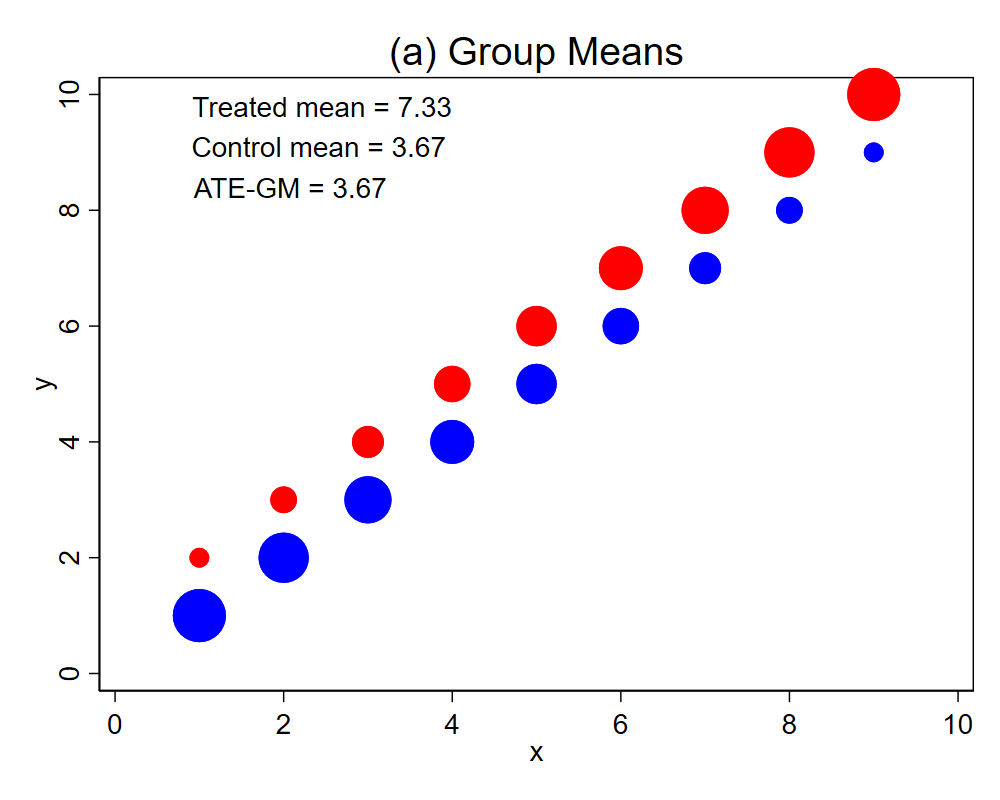

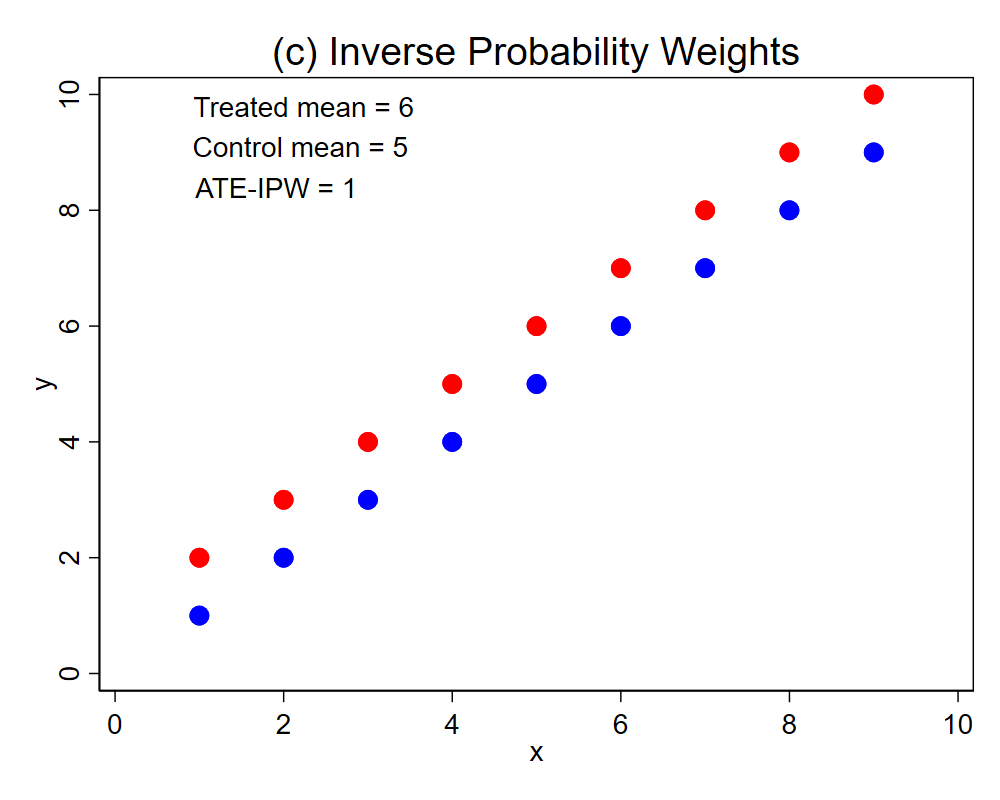

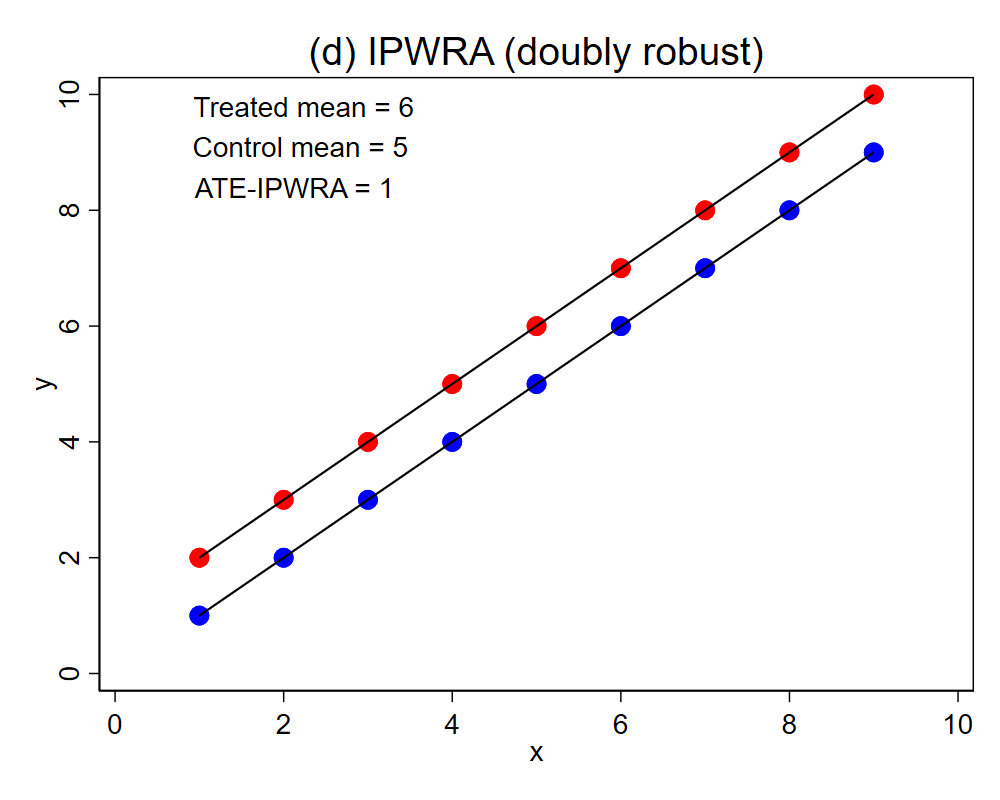

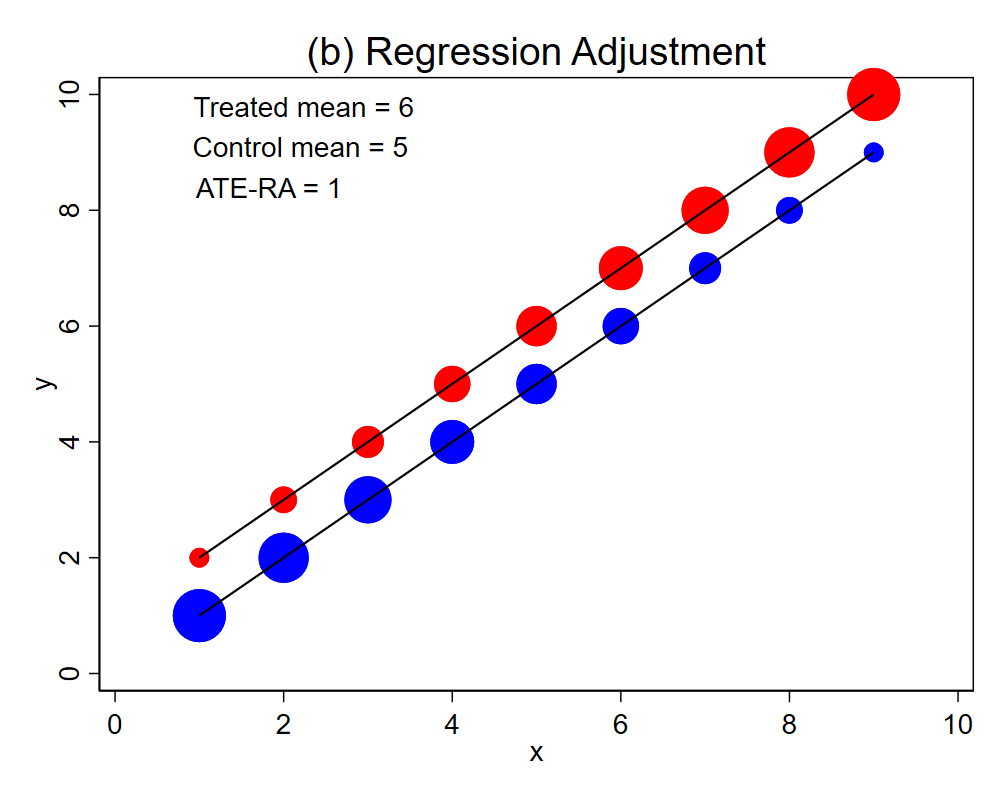

In [25]:
%%stata -os

* #================================================================================================
* # Figure 1. Illustrative scatters for GM, IP, RA, IPWRA
* #================================================================================================

preserve

* #control
clear
qui input x
1
2
3
4
5
6
7
8
9
end

* #p(treatment)=p(T) depends on x, n= nobs

qui gen nt = x
qui gen nc = 10-x

qui gen pt = nt/10
qui gen pc = nc/10

qui gen ipwt = 1/pt
sum ipwt
qui replace ipwt = ipwt/r(sum)

qui gen ipwc = 1/pc
sum ipwc
qui replace ipwc = ipwc/r(sum)

* #outcome y depends on x and T

qui gen yt = x + 1
qui gen yc = x

qui gen ten=10

* #means with n weghts

sum yc [fweight=nc]
sum yt [fweight=nt]


* #scatters

set scheme s1color

qui graph set window fontface "Palatino"

qui gr drop _all

qui twoway   (scatter yc x [w=nc], mc(blue)) (scatter yt x [w=nt], mc(red)) ///
	, ytitle("y") title("(a) Group Means") legend(off) ///
	text(9.8   1 "Treated mean = 7.33",  place(e)) ///
	text(9.1   1 "Control mean = 3.67",  place(e)) ///
	text(8.4   1 "ATE-GM = 3.67",        place(e)) 
	
qui gr rename GM

qui twoway  (scatter yc x [w=nc], mc(blue)) (scatter yt x [w=nt], mc(red))  (line yc x, lc(black)) (line yt x, lc(black)) ///
	, ytitle("y") title("(b) Regression Adjustment") legend(off) ///
	text(9.8   1 "Treated mean = 6",  place(e)) ///
	text(9.1   1 "Control mean = 5",  place(e)) ///
	text(8.4   1 "ATE-RA = 1",        place(e)) 
gr rename RA
	
qui twoway  (scatter yc x [w=ten], mc(blue)) (scatter yt x [w=ten], mc(red))  ///
	, ytitle("y") title("(c) Inverse Probability Weights") legend(off) ///
	text(9.8   1 "Treated mean = 6",  place(e)) ///
	text(9.1   1 "Control mean = 5",  place(e)) ///
	text(8.4   1 "ATE-IPW = 1",        place(e)) 
gr rename IPW
	
qui twoway  (scatter yc x [w=ten], mc(blue)) (scatter yt x [w=ten], mc(red)) (line yc x, lc(black)) (line yt x, lc(black))  ///
	, ytitle("y") title("(d) IPWRA (doubly robust)") legend(off) ///
	text(9.8   1 "Treated mean = 6",  place(e)) ///
	text(9.1   1 "Control mean = 5",  place(e)) ///
	text(8.4   1 "ATE-IPWRA = 1",        place(e)) 
gr rename IPWRA

restore

<a class='anchor' id='fig2'></a>
[Go to Table of Contents](#table_of_contents)

---
# Figure 2 (figure2.do)
---

![](https://github.com/htdanil/referenced_to_github/raw/master/GF0004_Jorda_Taylor_%282016%29_The_time_for_austerity__REPLICATION_WORK/results/fig2.PNG)

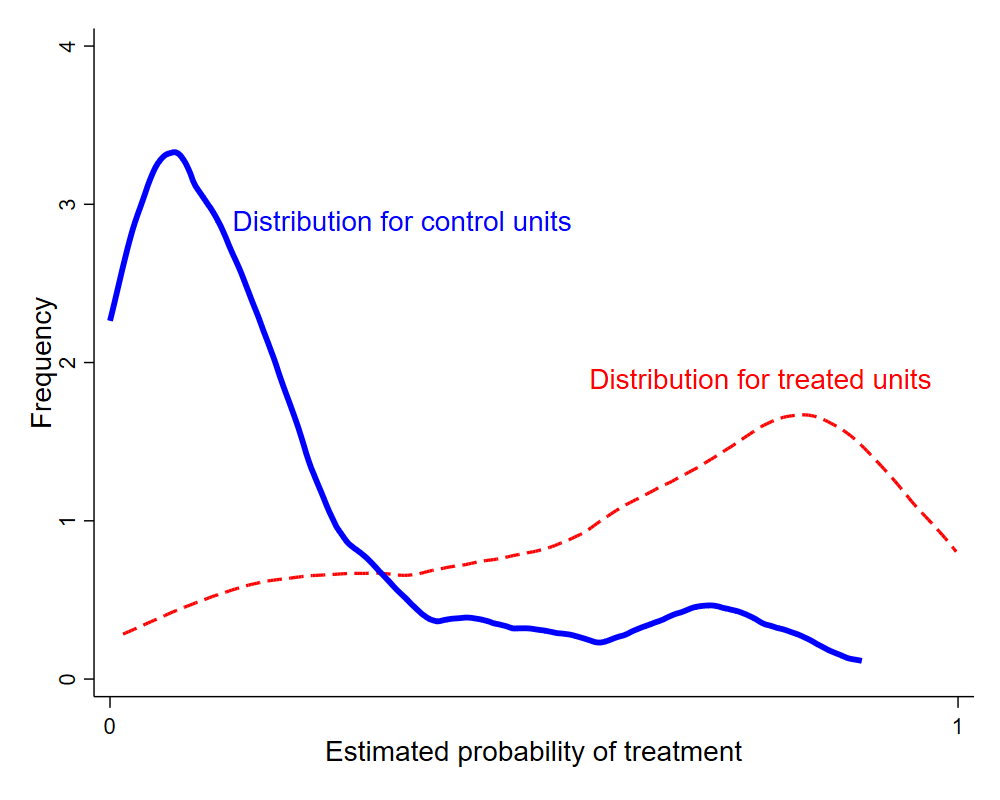

In [26]:
%%stata -os

twoway (kdensity pihat0 if ftreatment==1, lpattern(dash) color(red) lwidth(medthick)) ///
	(kdensity pihat0 if ftreatment==0, color(blue) lwidth(thick)), ///
	text(2.9 .16 "Distribution for control units", placement(e) color(blue) size()) ///
	text(1.9 .58 "Distribution for treated units", placement(e) color(red) size()) ///
	title("") legend(label(1 "Treatment dist.") label(2 "Control dist.")) ///
	ylabel(, labsize(small)) xlabel(0(1)1, labsize(small)) ///
	ytitle("Frequency") ///
	xtitle("Estimated probability of treatment") ///
	plotregion(lpattern(blank)) scheme(s1color) legend(off)

<a class='anchor' id='fig3'></a>
[Go to Table of Contents](#table_of_contents)

---
# Figure 3 (figure3.do)
---

![](https://github.com/htdanil/referenced_to_github/raw/master/GF0004_Jorda_Taylor_%282016%29_The_time_for_austerity__REPLICATION_WORK/results/Fig3.PNG)


(510 missing values generated)

(510 missing values generated)

(510 missing values generated)

(510 missing values generated)

(510 missing values generated)

(510 missing values generated)

(510 missing values generated)

(510 missing values generated)

(505 missing values generated)

(19 missing values generated)

(39 missing values generated)

. forvalues i=1/5 {
  2. * #SAME OUTCOME REG IN BOTH T&C THIS TIME, REST ALL THE SAME
  3. gen mu0=.
  4. gen mu1=.
  5. foreach bin in boom slump {
  6. 
  7. capture drop temp
  8. predict temp
  9. replace mu0 = temp if year>=1980 & year<=2007 & `bin'==1  
 10. 
 11. capture drop temp
 12. predict temp
 13. replace mu1 = temp if year>=1980 & year<=2007 & `bin'==1  
 14. }
 15. 
 16. generate iptw=(2*a-1)*ly`i'*invwt
 17. generate dr1 = iptw + mdiff1
 18. 
 19. qui gen ATE_IPWRA_slump  = slump
 20. quietly reg dr1 ATE_IPWRA_boom ATE_IPWRA_slump , nocons cluster(iso)
 21. 
 22. replace LPIPslump    = _b[ATE_IPWRA_slump]   if _Year==`i'
 23.

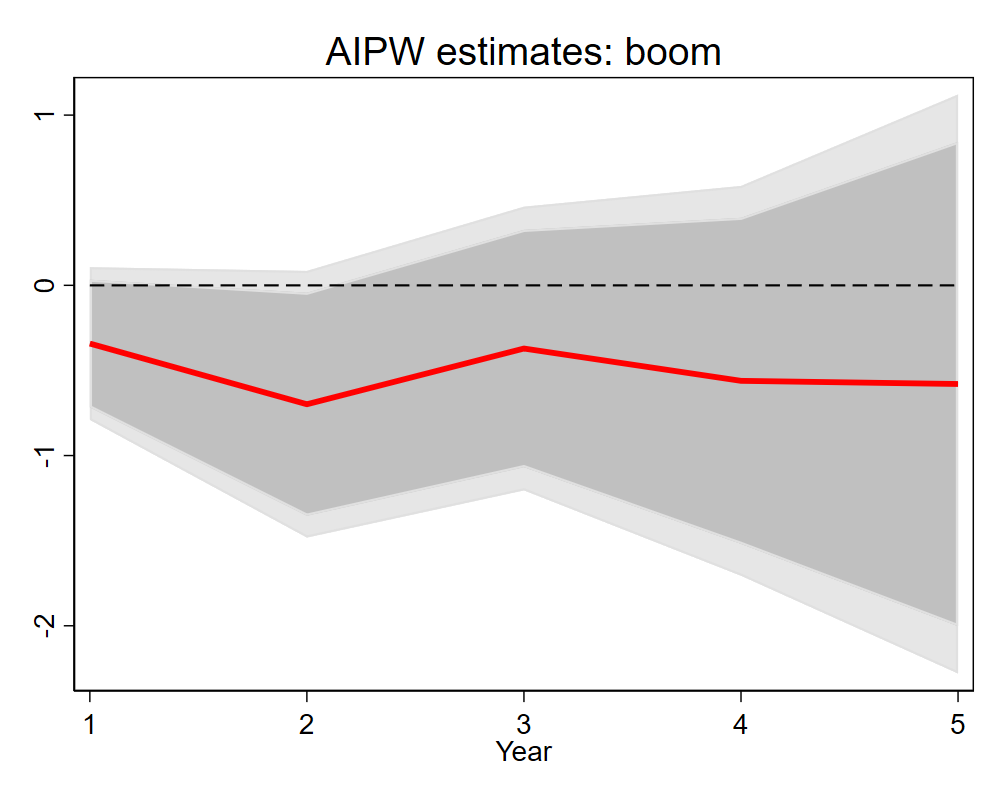

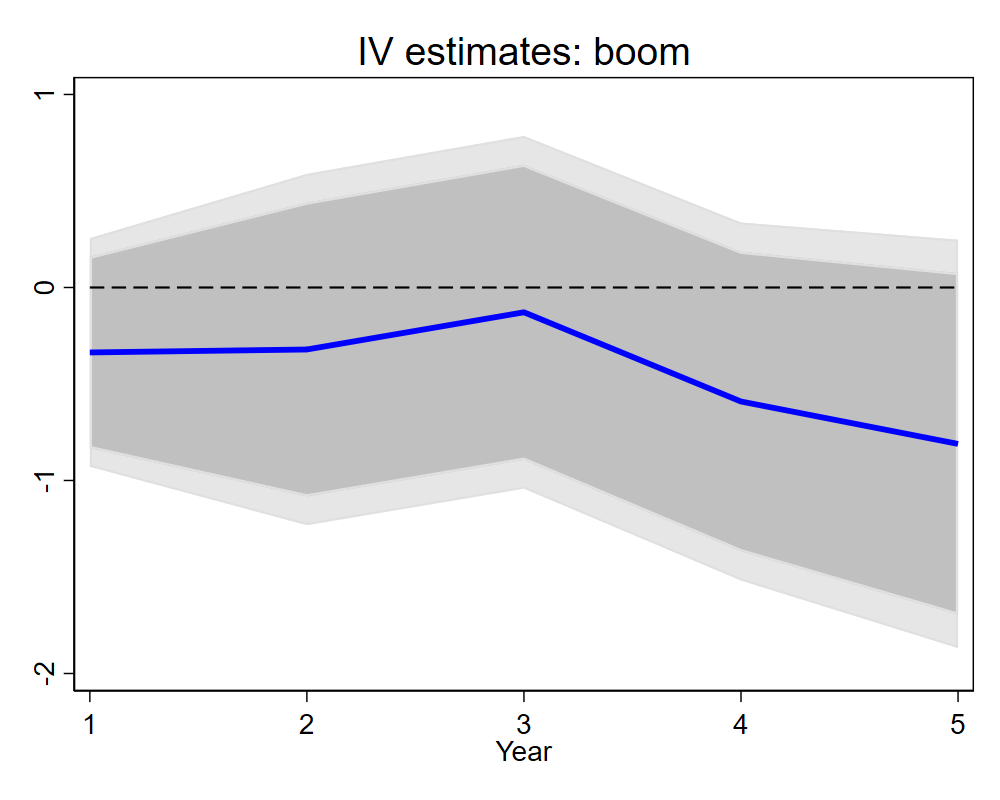

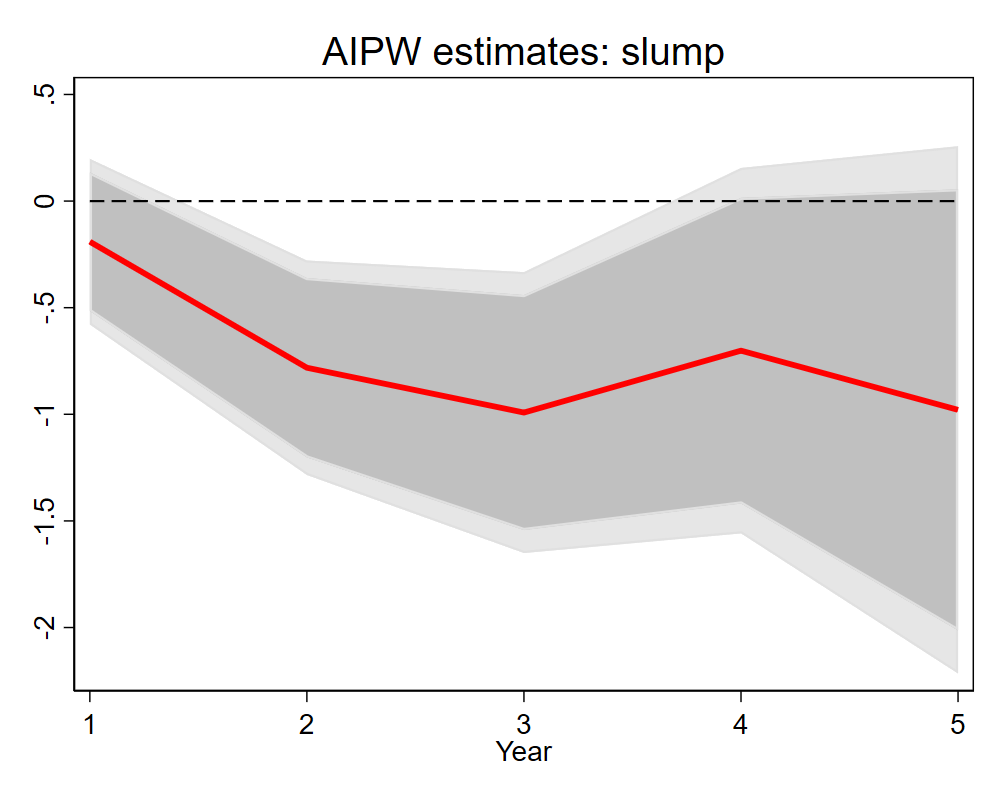

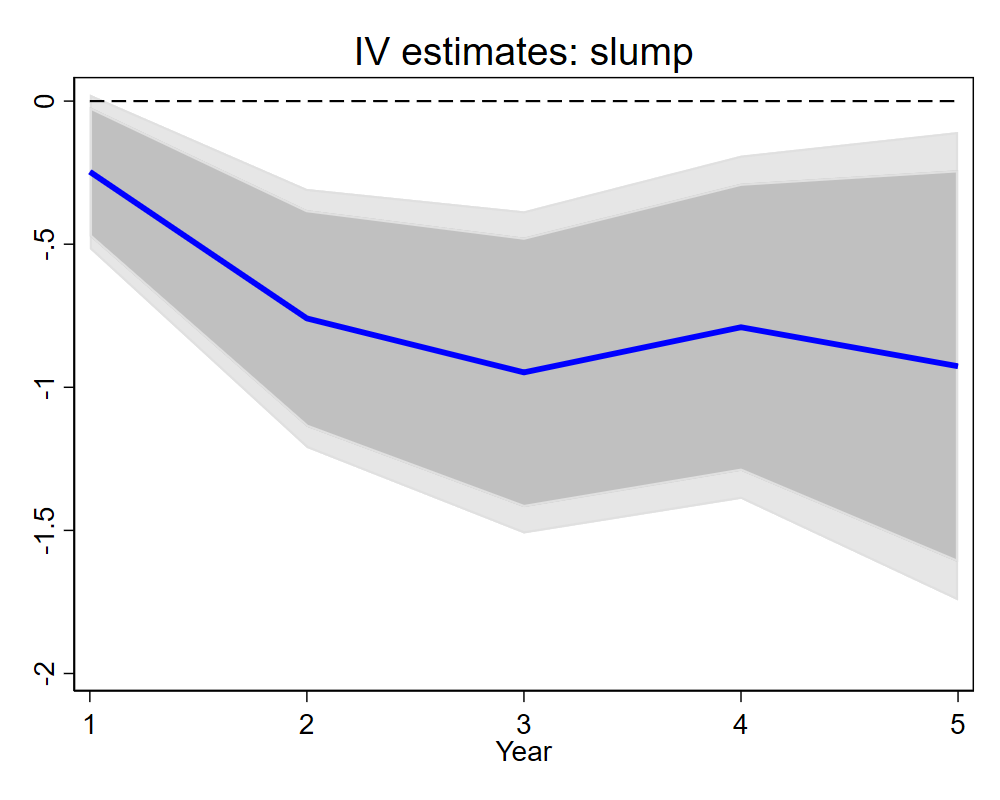

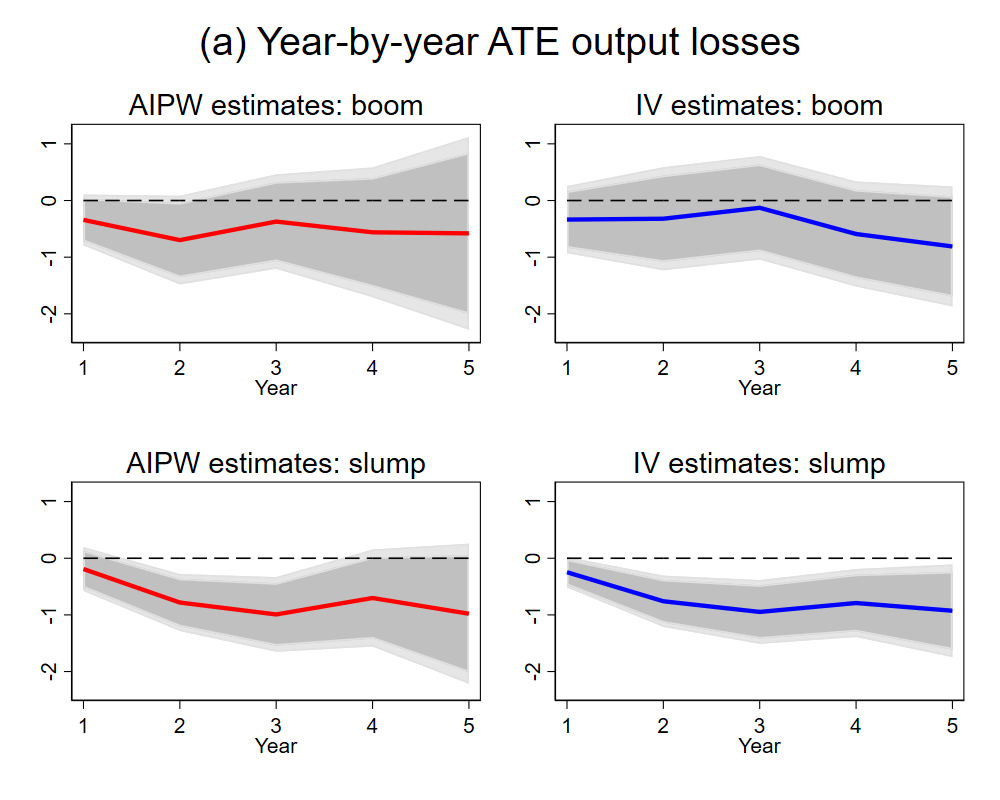

In [27]:
%%stata -os -o df_non_cummulative
* #================================================================================================
* # Figure3 replication
* #================================================================================================
* # ===========================================================================================
**** #first pass: use level impacts in each year
* # ===========================================================================================

* #----------------------------------------------------------------------------------------------------
* # creating columns for storing results
* #----------------------------------------------------------------------------------------------------
capture drop LPIV* LPIP* _Year
gen LPIVboom  = .
gen LPIVslump = .
gen LPIVboomse  = .
gen LPIVslumpse = .
gen LPIPboom  = .
gen LPIPslump = .
gen LPIPboomse  = .
gen LPIPslumpse = .
gen _Year = _n if _n <=5
label var _Year "Year"

* #----------------------------------------------------------------------------------------------------
* # Copied code from table 9
* #----------------------------------------------------------------------------------------------------

* #DR - IPWRA - ATE weighted by IPWT (Davidian/Lunt) WITH DIFFERENT SLOPE/CFEs (beta1.NEQ.beta0)
* #ATE split by bin
* #no truncations (use phat0)
capture drop a invwt
gen a=ftreatment // #define treatment indicator as a from Lunt et al.
gen invwt=a/pihat0 + (1-a)/(1-pihat0) if pihat~=. // #invwt from Lunt et al.

forvalues i=1/5 {
	* #SAME OUTCOME REG IN BOTH T&C THIS TIME, REST ALL THE SAME
	capture drop mu1 mu0
	gen mu0=.
	gen mu1=.
	foreach bin in boom slump {
	
		quietly reg ly`i'  hply dml0dly  dml1dly dmdumiso1-dmdumiso16 [pweight=invwt] ///
			if year>=1980 & year<=2007 & `bin'==1 & ftreatment==0,  cluster(iso)
		capture drop temp
		predict temp
		replace mu0 = temp if year>=1980 & year<=2007 & `bin'==1  

		
		quietly reg ly`i'  hply dml0dly  dml1dly dmdumiso1-dmdumiso16 [pweight=invwt] ///
			if year>=1980 & year<=2007 & `bin'==1 & ftreatment==1,  cluster(iso)
		capture drop temp
		predict temp
		replace mu1 = temp if year>=1980 & year<=2007 & `bin'==1  
		}
		
	* #from Lunt et al
	generate mdiff1=(-(a-pihat0)*mu1/pihat0)-((a-pihat0)*mu0/(1-pihat0))
	generate iptw=(2*a-1)*ly`i'*invwt
	generate dr1 = iptw + mdiff1
	

	qui gen ATE_IPWRA_boom  = boom  // #constant for convenience in next reg to get mean
	qui gen ATE_IPWRA_slump  = slump  // #constant for convenience in next reg to get mean
	quietly reg dr1 ATE_IPWRA_boom ATE_IPWRA_slump , nocons cluster(iso)
	
	* #store for charts
	replace LPIPboom     = _b[ATE_IPWRA_boom]    if _Year==`i'
	replace LPIPslump    = _b[ATE_IPWRA_slump]   if _Year==`i'
	replace LPIPboomse 	 = _se[ATE_IPWRA_boom]   if _Year==`i'
	replace LPIPslumpse  = _se[ATE_IPWRA_slump]   if _Year==`i'


	drop iptw mdiff1 dr1 mu1 mu0 ATE_IPWRA*
}


* #----------------------------------------------------------------------------------------------------
* #Table 4: Fiscal multiplier, d.CAPB, IV estimate (binary), boom/slump
* #----------------------------------------------------------------------------------------------------
capture drop zboom zslump
foreach c in boom slump {
    gen z`c'=f.treatment*`c'
}

forvalues i = 1/5   {
    foreach c in boom slump {
        * #the dummy for the U.S. is dropped to avoid collinearity with the constant
        quietly ivreg2 ly`i'   (fAA= zboom zslump) ///
            hply dml0dly dml1dly dmdumiso1-dmdumiso16 ///
            if `c'==1 & year>=1980 & year<=2007,  cluster(iso) 
		
		* #store for charts
		replace LPIV`c'    = _b[fAA]       if _Year==`i'
		replace LPIV`c'se  = _se[fAA]      if _Year==`i'
    }
}


* #----------------------------------------------------------------------------------------------------
* # Chart work start
* #----------------------------------------------------------------------------------------------------
capture drop x_* up_* dn_* up10_* dn10_*

* # SCALE UP GIVEN AVG TREATMENT SIZE IN EACH BIN
local scaling_LPIPboom   1.00/0.9726035
local scaling_LPIPslump  1.00/0.9726035
local scaling_LPIVboom   1.00
local scaling_LPIVslump  1.00

foreach s in LPIPboom LPIPslump LPIVboom LPIVslump {
		gen x_`s'      = `scaling_`s'' * `s' //# main IRF
		gen up_`s'     = `scaling_`s'' * (`s' + 1.96 * `s'se) //# 5% level of significance
		gen dn_`s'     = `scaling_`s'' * (`s' - 1.96 * `s'se) //# 5% level of significance
		gen up10_`s'   = `scaling_`s'' * (`s' + 1.64 * `s'se) //# 10% level of significance
		gen dn10_`s'   = `scaling_`s'' * (`s' - 1.64 * `s'se) //# 10% level of significance
	}
	
capture drop _Zero
gen _Zero = 0


twoway	(rarea up_LPIPboom dn_LPIPboom _Year, ///
				fcolor(gs14) lcolor(gs14) lpattern(solid)) ///
		(rarea up10_LPIPboom dn10_LPIPboom _Year, ///
				fcolor(gs11) lcolor(gs14) lpattern(solid)) ///
		(line x_LPIPboom _Year, lcolor(red) lpattern(solid) lwidth(thick)) ///
		(line _Zero _Year, lcolor(black) lpattern(dash) lwidth(med)) ///
		, legend(off) title("AIPW estimates: boom")
		graph rename g1a

twoway	(rarea up_LPIVboom dn_LPIVboom _Year, ///
				fcolor(gs14) lcolor(gs14) lpattern(solid)) ///
		(rarea up10_LPIVboom dn10_LPIVboom _Year, ///
				fcolor(gs11) lcolor(gs14) lpattern(solid)) ///
		(line x_LPIVboom _Year, lcolor(blue) lpattern(solid) lwidth(thick)) ///
		(line _Zero _Year, lcolor(black) lpattern(dash) lwidth(med)) ///
		, legend(off) title("IV estimates: boom")
		graph rename g2a

		
twoway	(rarea up_LPIPslump dn_LPIPslump _Year, ///
				fcolor(gs14) lcolor(gs14) lpattern(solid)) ///
		(rarea up10_LPIPslump dn10_LPIPslump _Year, ///
				fcolor(gs11) lcolor(gs14) lpattern(solid)) ///
		(line x_LPIPslump _Year, lcolor(red) lpattern(solid) lwidth(thick)) ///
		(line _Zero _Year, lcolor(black) lpattern(dash) lwidth(med)) ///
		, legend(off) title("AIPW estimates: slump")
		graph rename g3a
		

twoway	(rarea up_LPIVslump dn_LPIVslump _Year, ///
				fcolor(gs14) lcolor(gs14) lpattern(solid)) ///
		(rarea up10_LPIVslump dn10_LPIVslump _Year, ///
				fcolor(gs11) lcolor(gs14) lpattern(solid)) ///
		(line x_LPIVslump _Year, lcolor(blue) lpattern(solid) lwidth(thick)) ///
		(line _Zero _Year, lcolor(black) lpattern(dash) lwidth(med)) ///
		, legend(off) title("IV estimates: slump")
		graph rename g4a
	

gr combine g1a g2a g3a g4a, ycommon title("(a) Year-by-year ATE output losses")
graph rename ga

(476 real changes made)

(459 real changes made)

(442 real changes made)

(425 real changes made)

(510 missing values generated)

(510 missing values generated)

(510 missing values generated)

(510 missing values generated)

(510 missing values generated)

(510 missing values generated)

(510 missing values generated)

(510 missing values generated)

(505 missing values generated)

(19 missing values generated)

(39 missing values generated)

. forvalues i=1/5 {
  2. * #SAME OUTCOME REG IN BOTH T&C THIS TIME, REST ALL THE SAME
  3. gen mu0=.
  4. gen mu1=.
  5. foreach bin in boom slump {
  6. 
  7. capture drop temp
  8. predict temp
  9. replace mu0 = temp if year>=1980 & year<=2007 & `bin'==1  
 10. 
 11. capture drop temp
 12. predict temp
 13. replace mu1 = temp if year>=1980 & year<=2007 & `bin'==1  
 14. }
 15. 
 16. generate iptw=(2*a-1)*ly`i'*invwt
 17. generate dr1 = iptw + mdiff1
 18. 
 19. qui gen ATE_IPWRA_slump  = slump
 20. quietly reg dr1 ATE_IPWRA_boom ATE_IPWRA_slu

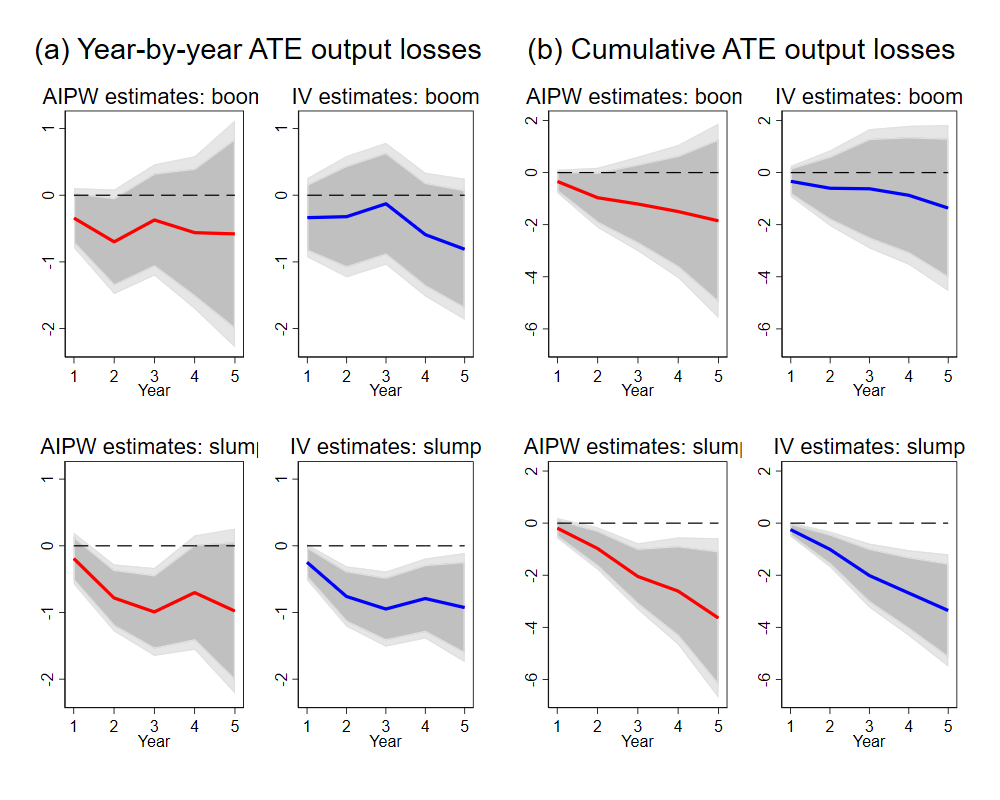

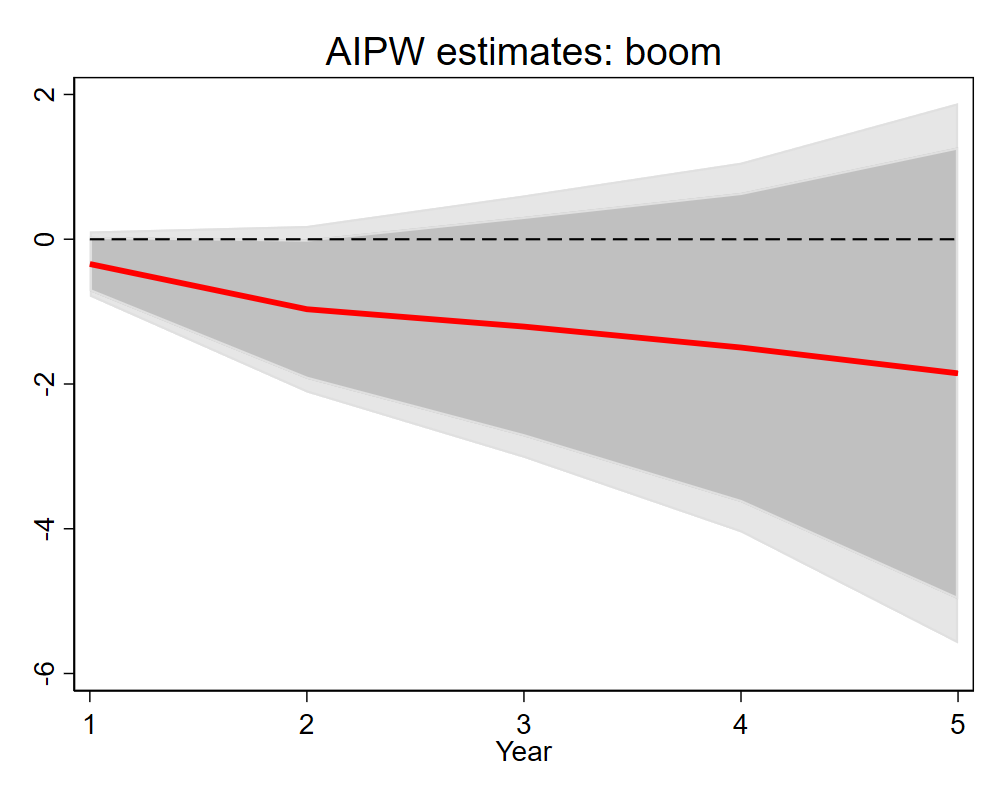

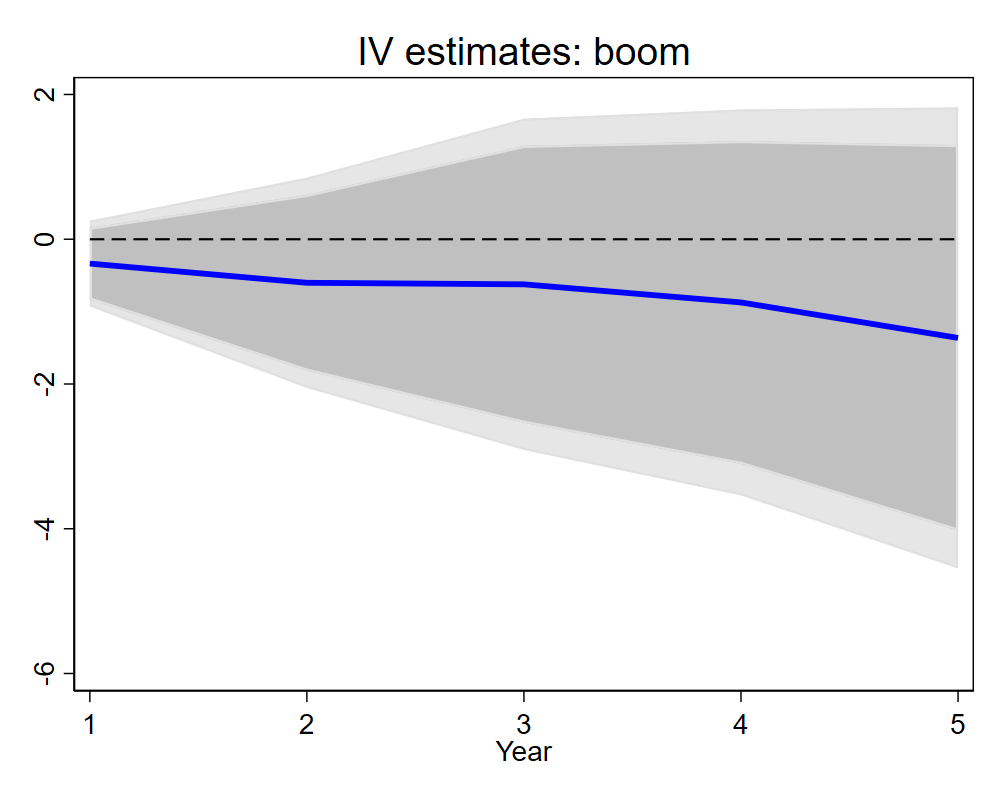

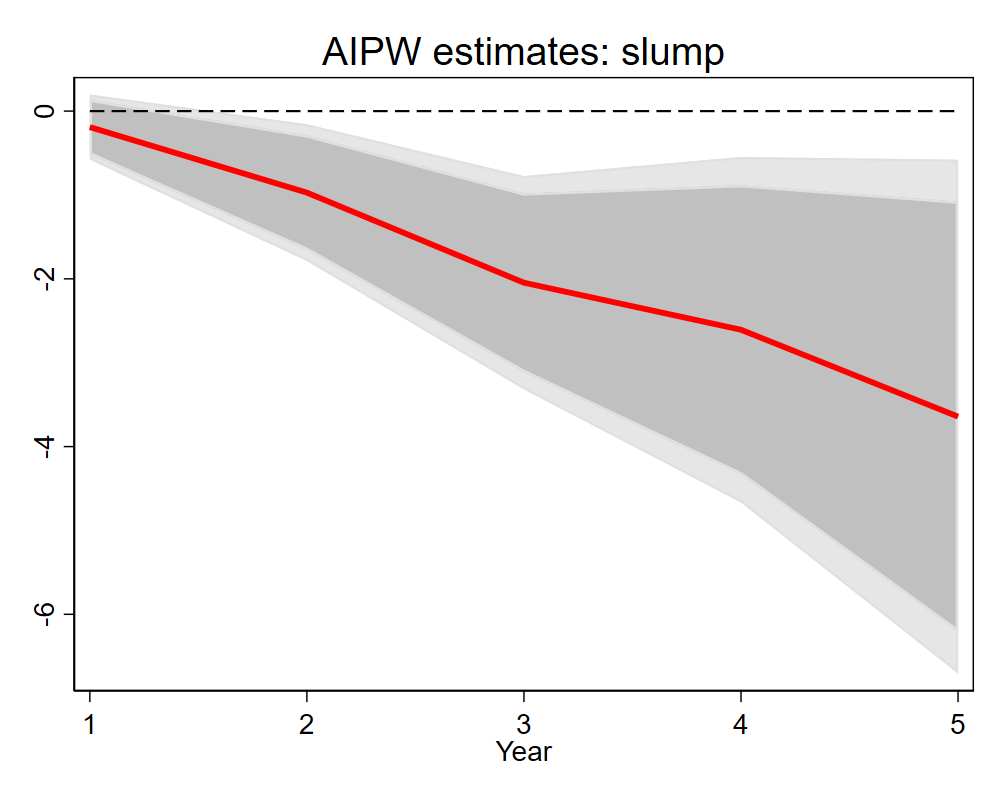

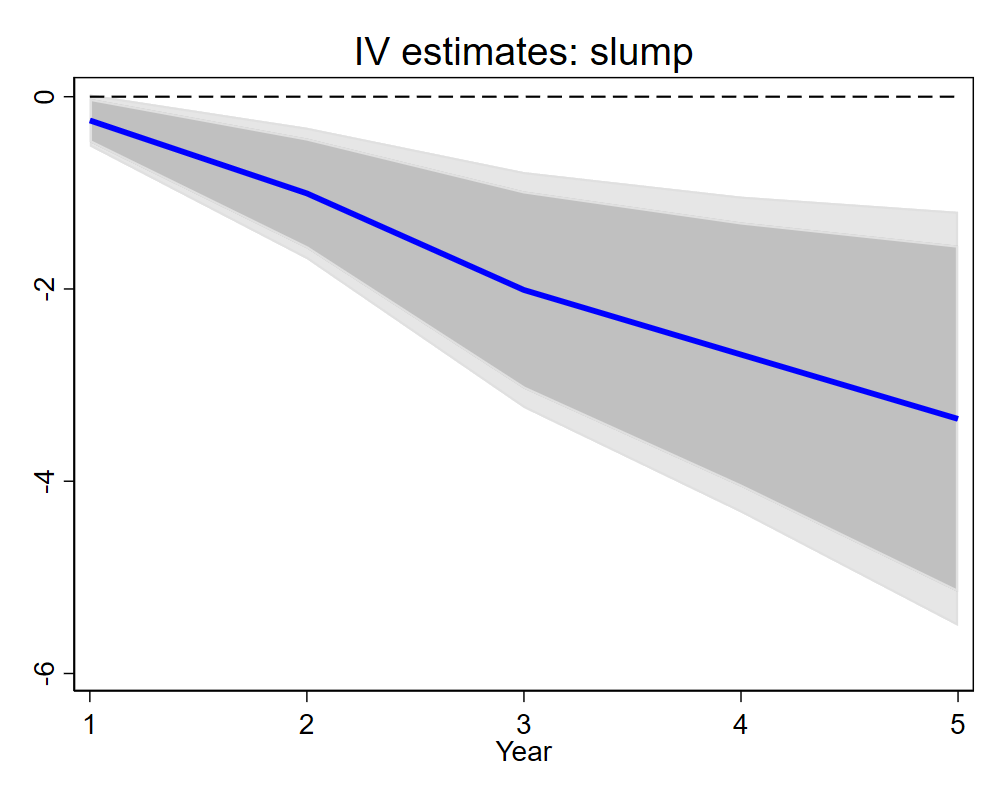

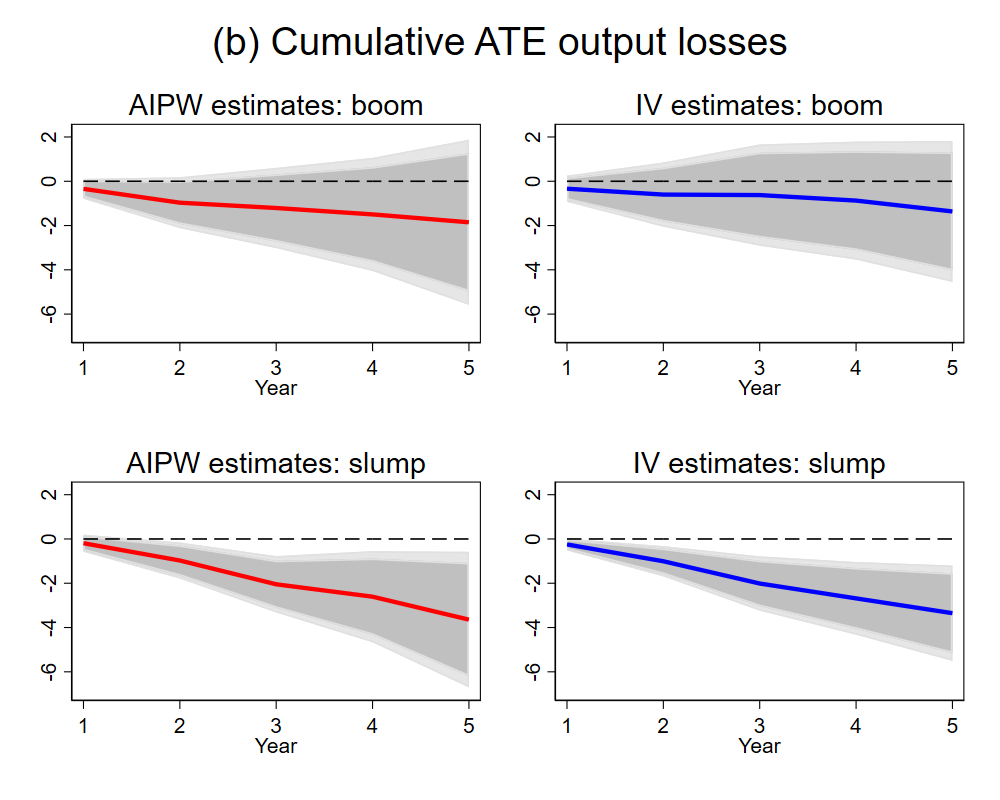

In [28]:
%%stata -os -o df_cummulative
* # ===========================================================================================
**** #second pass: use cumulative impacts up to each year
* # ===========================================================================================
replace ly2 = ly1 + ly2
replace ly3 = ly2 + ly3
replace ly4 = ly3 + ly4
replace ly5 = ly4 + ly5

* #----------------------------------------------------------------------------------------------------
* # creating columns for storing results
* #----------------------------------------------------------------------------------------------------
capture drop LPIV* LPIP* _Year
gen LPIVboom  = .
gen LPIVslump = .
gen LPIVboomse  = .
gen LPIVslumpse = .
gen LPIPboom  = .
gen LPIPslump = .
gen LPIPboomse  = .
gen LPIPslumpse = .
gen _Year = _n if _n <=5
label var _Year "Year"

* #----------------------------------------------------------------------------------------------------
* # Copied code from table 9
* #----------------------------------------------------------------------------------------------------

* #DR - IPWRA - ATE weighted by IPWT (Davidian/Lunt) WITH DIFFERENT SLOPE/CFEs (beta1.NEQ.beta0)
* #ATE split by bin
* #no truncations (use phat0)
capture drop a invwt
gen a=ftreatment // #define treatment indicator as a from Lunt et al.
gen invwt=a/pihat0 + (1-a)/(1-pihat0) if pihat~=. // #invwt from Lunt et al.

forvalues i=1/5 {
	* #SAME OUTCOME REG IN BOTH T&C THIS TIME, REST ALL THE SAME
	capture drop mu1 mu0
	gen mu0=.
	gen mu1=.
	foreach bin in boom slump {
	
		quietly reg ly`i'  hply dml0dly  dml1dly dmdumiso1-dmdumiso16 [pweight=invwt] ///
			if year>=1980 & year<=2007 & `bin'==1 & ftreatment==0,  cluster(iso)
		capture drop temp
		predict temp
		replace mu0 = temp if year>=1980 & year<=2007 & `bin'==1  

		
		quietly reg ly`i'  hply dml0dly  dml1dly dmdumiso1-dmdumiso16 [pweight=invwt] ///
			if year>=1980 & year<=2007 & `bin'==1 & ftreatment==1,  cluster(iso)
		capture drop temp
		predict temp
		replace mu1 = temp if year>=1980 & year<=2007 & `bin'==1  
		}
		
	* #from Lunt et al
	generate mdiff1=(-(a-pihat0)*mu1/pihat0)-((a-pihat0)*mu0/(1-pihat0))
	generate iptw=(2*a-1)*ly`i'*invwt
	generate dr1 = iptw + mdiff1
	

	qui gen ATE_IPWRA_boom  = boom  // #constant for convenience in next reg to get mean
	qui gen ATE_IPWRA_slump  = slump  // #constant for convenience in next reg to get mean
	quietly reg dr1 ATE_IPWRA_boom ATE_IPWRA_slump , nocons cluster(iso)
	
	* #store for charts
	replace LPIPboom     = _b[ATE_IPWRA_boom]    if _Year==`i'
	replace LPIPslump    = _b[ATE_IPWRA_slump]   if _Year==`i'
	replace LPIPboomse 	 = _se[ATE_IPWRA_boom]   if _Year==`i'
	replace LPIPslumpse  = _se[ATE_IPWRA_slump]   if _Year==`i'


	drop iptw mdiff1 dr1 mu1 mu0 ATE_IPWRA*
}


* #----------------------------------------------------------------------------------------------------
* #Table 4: Fiscal multiplier, d.CAPB, IV estimate (binary), boom/slump
* #----------------------------------------------------------------------------------------------------
capture drop zboom zslump
foreach c in boom slump {
    gen z`c'=f.treatment*`c'
}

forvalues i = 1/5   {
    foreach c in boom slump {
        * #the dummy for the U.S. is dropped to avoid collinearity with the constant
        quietly ivreg2 ly`i'   (fAA= zboom zslump) ///
            hply dml0dly dml1dly dmdumiso1-dmdumiso16 ///
            if `c'==1 & year>=1980 & year<=2007,  cluster(iso) 
		
		* #store for charts
		replace LPIV`c'    = _b[fAA]       if _Year==`i'
		replace LPIV`c'se  = _se[fAA]      if _Year==`i'
    }
}



* #----------------------------------------------------------------------------------------------------
* # Chart work start
* #----------------------------------------------------------------------------------------------------
capture drop x_* up_* dn_* up10_* dn10_*

* # SCALE UP GIVEN AVG TREATMENT SIZE IN EACH BIN
local scaling_LPIPboom   1.00/0.9726035
local scaling_LPIPslump  1.00/0.9726035
local scaling_LPIVboom   1.00
local scaling_LPIVslump  1.00

foreach s in LPIPboom LPIPslump LPIVboom LPIVslump {
		gen x_`s'      = `scaling_`s'' * `s' //# main IRF
		gen up_`s'     = `scaling_`s'' * (`s' + 1.96 * `s'se) //# 5% level of significance
		gen dn_`s'     = `scaling_`s'' * (`s' - 1.96 * `s'se) //# 5% level of significance
		gen up10_`s'   = `scaling_`s'' * (`s' + 1.64 * `s'se) //# 10% level of significance
		gen dn10_`s'   = `scaling_`s'' * (`s' - 1.64 * `s'se) //# 10% level of significance
	}
	
capture drop _Zero
gen _Zero = 0

twoway	(rarea up_LPIPboom dn_LPIPboom _Year, ///
				fcolor(gs14) lcolor(gs14) lpattern(solid)) ///
		(rarea up10_LPIPboom dn10_LPIPboom _Year, ///
				fcolor(gs11) lcolor(gs14) lpattern(solid)) ///
		(line x_LPIPboom _Year, lcolor(red) lpattern(solid) lwidth(thick)) ///
		(line _Zero _Year, lcolor(black) lpattern(dash) lwidth(med)) ///
		, legend(off) title("AIPW estimates: boom")
		graph rename g1b

twoway	(rarea up_LPIVboom dn_LPIVboom _Year, ///
				fcolor(gs14) lcolor(gs14) lpattern(solid)) ///
		(rarea up10_LPIVboom dn10_LPIVboom _Year, ///
				fcolor(gs11) lcolor(gs14) lpattern(solid)) ///
		(line x_LPIVboom _Year, lcolor(blue) lpattern(solid) lwidth(thick)) ///
		(line _Zero _Year, lcolor(black) lpattern(dash) lwidth(med)) ///
		, legend(off) title("IV estimates: boom")
		graph rename g2b

		
twoway	(rarea up_LPIPslump dn_LPIPslump _Year, ///
				fcolor(gs14) lcolor(gs14) lpattern(solid)) ///
		(rarea up10_LPIPslump dn10_LPIPslump _Year, ///
				fcolor(gs11) lcolor(gs14) lpattern(solid)) ///
		(line x_LPIPslump _Year, lcolor(red) lpattern(solid) lwidth(thick)) ///
		(line _Zero _Year, lcolor(black) lpattern(dash) lwidth(med)) ///
		, legend(off) title("AIPW estimates: slump")
		graph rename g3b
		

twoway	(rarea up_LPIVslump dn_LPIVslump _Year, ///
				fcolor(gs14) lcolor(gs14) lpattern(solid)) ///
		(rarea up10_LPIVslump dn10_LPIVslump _Year, ///
				fcolor(gs11) lcolor(gs14) lpattern(solid)) ///
		(line x_LPIVslump _Year, lcolor(blue) lpattern(solid) lwidth(thick)) ///
		(line _Zero _Year, lcolor(black) lpattern(dash) lwidth(med)) ///
		, legend(off) title("IV estimates: slump")
		graph rename g4b
	
gr combine g1b g2b g3b g4b, ycommon title("(b) Cumulative ATE output losses")
graph rename gb

gr combine ga gb , // #no title

* #graph drop _all

<a class='anchor' id='fig3_python'></a>
[Go to Table of Contents](#table_of_contents)

---
# Figure 3 (Using Python)
---

In [29]:
columns_to_retain = [x for x in df_non_cummulative if 'x_' in x or 'up' in x or 'dn' in x]
columns_to_retain.append('_Year')

df_non_cummulative = df_non_cummulative[columns_to_retain].head(5)
df_cummulative = df_cummulative[columns_to_retain].head(5)

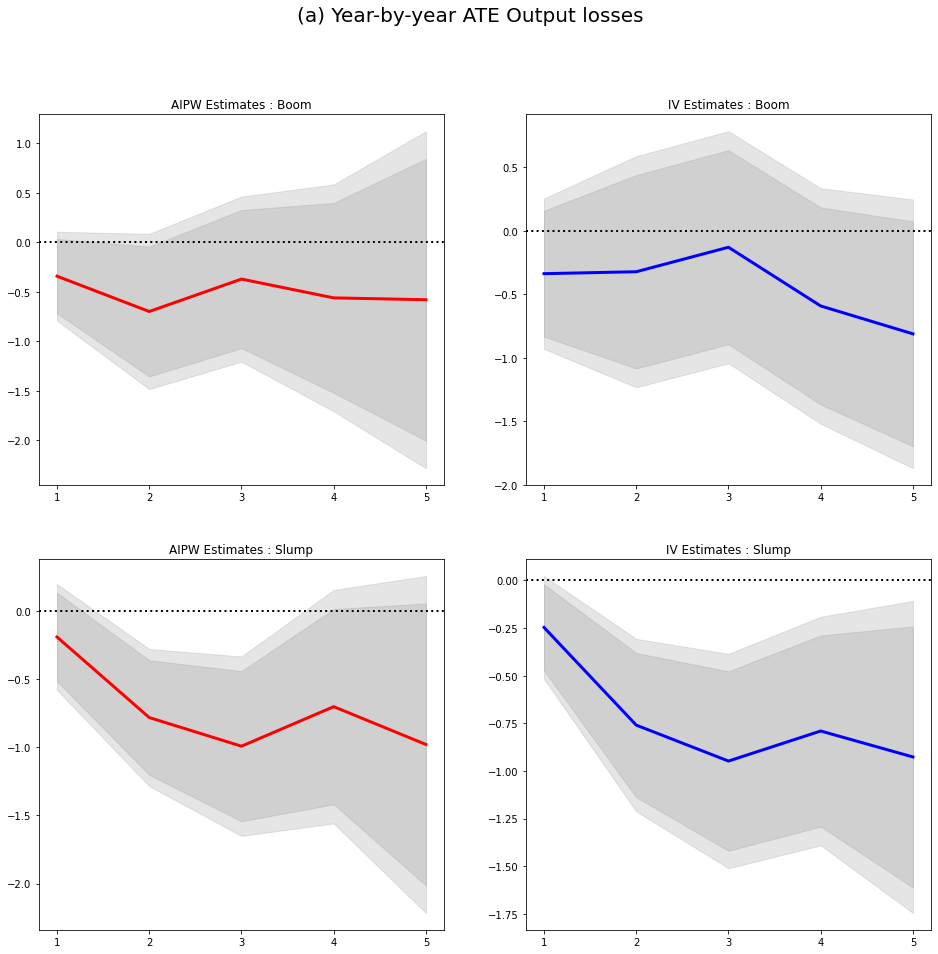

In [30]:
import matplotlib.pyplot as plt
import numpy as np

x = [1,2,3,4,5]

fig = plt.figure(figsize=(16,15))
fig.suptitle("(a) Year-by-year ATE Output losses",size=20)
ax1 = fig.add_subplot(2,2,1)
ax2 = fig.add_subplot(2,2,2)
ax3 = fig.add_subplot(2,2,3)
ax4 = fig.add_subplot(2,2,4)

ax1.plot(x, list(df_non_cummulative['x_LPIPboom']), color='red', linewidth=3)
ax1.fill_between(x, list(df_non_cummulative['up_LPIPboom']), list(df_non_cummulative['dn_LPIPboom']), color='grey', alpha=0.2)
ax1.fill_between(x, list(df_non_cummulative['up10_LPIPboom']), list(df_non_cummulative['dn10_LPIPboom']), color='grey', alpha=0.2)
ax1.axhline(0, color='black', linestyle=':', linewidth=2)
ax1.set_title('AIPW Estimates : Boom')
ax1.set_xticks(x, minor=False)

ax2.plot(x, list(df_non_cummulative['x_LPIVboom']), color='blue', linewidth=3)
ax2.fill_between(x, list(df_non_cummulative['up_LPIVboom']), list(df_non_cummulative['dn_LPIVboom']), color='grey', alpha=0.2)
ax2.fill_between(x, list(df_non_cummulative['up10_LPIVboom']), list(df_non_cummulative['dn10_LPIVboom']), color='grey', alpha=0.2)
ax2.axhline(0, color='black', linestyle=':', linewidth=2)
ax2.set_title('IV Estimates : Boom')
ax2.set_xticks(x, minor=False)

ax3.plot(x,list(df_non_cummulative['x_LPIPslump']), color='red', linewidth=3)
ax3.fill_between(x, list(df_non_cummulative['up_LPIPslump']), list(df_non_cummulative['dn_LPIPslump']), color='grey', alpha=0.2)
ax3.fill_between(x, list(df_non_cummulative['up10_LPIPslump']), list(df_non_cummulative['dn10_LPIPslump']), color='grey', alpha=0.2)
ax3.axhline(0, color='black', linestyle=':', linewidth=2)
ax3.set_title('AIPW Estimates : Slump')
ax3.set_xticks(x, minor=False)

ax4.plot(x, list(df_non_cummulative['x_LPIVslump']), color='blue', linewidth=3)
ax4.fill_between(x, list(df_non_cummulative['up_LPIVslump']), list(df_non_cummulative['dn_LPIVslump']), color='grey', alpha=0.2)
ax4.fill_between(x, list(df_non_cummulative['up10_LPIVslump']), list(df_non_cummulative['dn10_LPIVslump']), color='grey', alpha=0.2)
ax4.axhline(0, color='black', linestyle=':', linewidth=2)
ax4.set_title('IV Estimates : Slump')
ax4.set_xticks(x, minor=False)

plt.show()

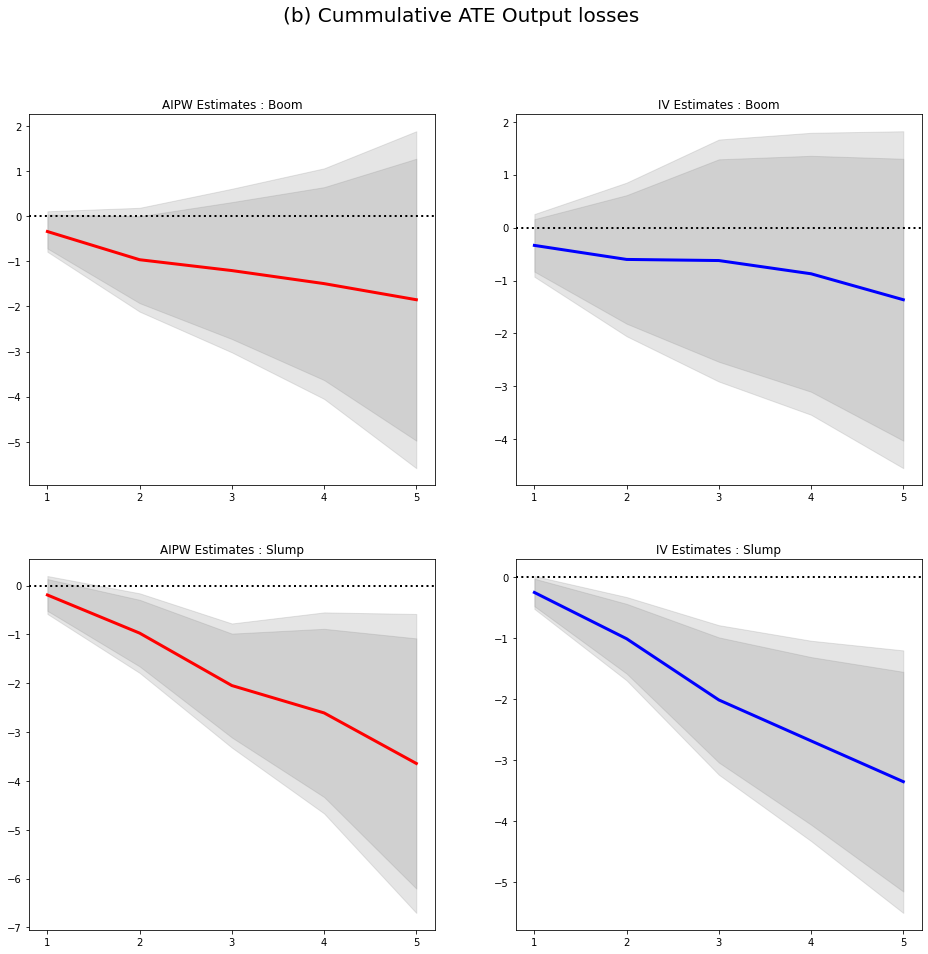

In [31]:
x = [1,2,3,4,5]

fig = plt.figure(figsize=(16,15))
fig.suptitle("(b) Cummulative ATE Output losses",size=20)
ax1 = fig.add_subplot(2,2,1)
ax2 = fig.add_subplot(2,2,2)
ax3 = fig.add_subplot(2,2,3)
ax4 = fig.add_subplot(2,2,4)

ax1.plot(x, list(df_cummulative['x_LPIPboom']), color='red', linewidth=3)
ax1.fill_between(x, list(df_cummulative['up_LPIPboom']), list(df_cummulative['dn_LPIPboom']), color='grey', alpha=0.2)
ax1.fill_between(x, list(df_cummulative['up10_LPIPboom']), list(df_cummulative['dn10_LPIPboom']), color='grey', alpha=0.2)
ax1.axhline(0, color='black', linestyle=':', linewidth=2)
ax1.set_title('AIPW Estimates : Boom')
ax1.set_xticks(x, minor=False)

ax2.plot(x, list(df_cummulative['x_LPIVboom']), color='blue', linewidth=3)
ax2.fill_between(x, list(df_cummulative['up_LPIVboom']), list(df_cummulative['dn_LPIVboom']), color='grey', alpha=0.2)
ax2.fill_between(x, list(df_cummulative['up10_LPIVboom']), list(df_cummulative['dn10_LPIVboom']), color='grey', alpha=0.2)
ax2.axhline(0, color='black', linestyle=':', linewidth=2)
ax2.set_title('IV Estimates : Boom')
ax2.set_xticks(x, minor=False)

ax3.plot(x,list(df_cummulative['x_LPIPslump']), color='red', linewidth=3)
ax3.fill_between(x, list(df_cummulative['up_LPIPslump']), list(df_cummulative['dn_LPIPslump']), color='grey', alpha=0.2)
ax3.fill_between(x, list(df_cummulative['up10_LPIPslump']), list(df_cummulative['dn10_LPIPslump']), color='grey', alpha=0.2)
ax3.axhline(0, color='black', linestyle=':', linewidth=2)
ax3.set_title('AIPW Estimates : Slump')
ax3.set_xticks(x, minor=False)

ax4.plot(x, list(df_cummulative['x_LPIVslump']), color='blue', linewidth=3)
ax4.fill_between(x, list(df_cummulative['up_LPIVslump']), list(df_cummulative['dn_LPIVslump']), color='grey', alpha=0.2)
ax4.fill_between(x, list(df_cummulative['up10_LPIVslump']), list(df_cummulative['dn10_LPIVslump']), color='grey', alpha=0.2)
ax4.axhline(0, color='black', linestyle=':', linewidth=2)
ax4.set_title('IV Estimates : Slump')
ax4.set_xticks(x, minor=False)

plt.show()